In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import neurokit2 as nk
import numpy as np
import json
from feature_engine.outliers import Winsorizer

# load data

{'event_cue': {'start': [15306, 103905, 185503, 245904, 301715, 375907, 435503, 491503, 554306, 618503, 677504, 742503], 'stop': [17267, 105867, 187467, 247867, 303668, 377866, 437466, 493466, 556266, 620466, 679466, 744466]}, 'event_expectrating': {'start': [19135, 109105, 191303, 252501, 305312, 380106, 439702, 496502, 560508, 623101, 683701, 747110], 'stop': [23007, 113241, 195738, 258368, 311348, 385175, 445202, 501202, 563442, 627002, 690168, 749945]}, 'event_stimuli': {'start': [41799, 133175, 206349, 264565, 329351, 392129, 455562, 510536, 580161, 635124, 704345, 759178], 'stop': [59667, 151067, 224267, 282467, 347268, 410066, 473466, 528466, 598066, 653066, 722266, 777066]}, 'event_actualrating': {'start': [78301, 166901, 231901, 285105, 354531, 414101, 477509, 535702, 609502, 660711, 732905, 788702], 'stop': [82635, 169935, 236102, 290006, 357968, 417769, 482311, 542502, 615302, 665747, 737673, 792669]}}


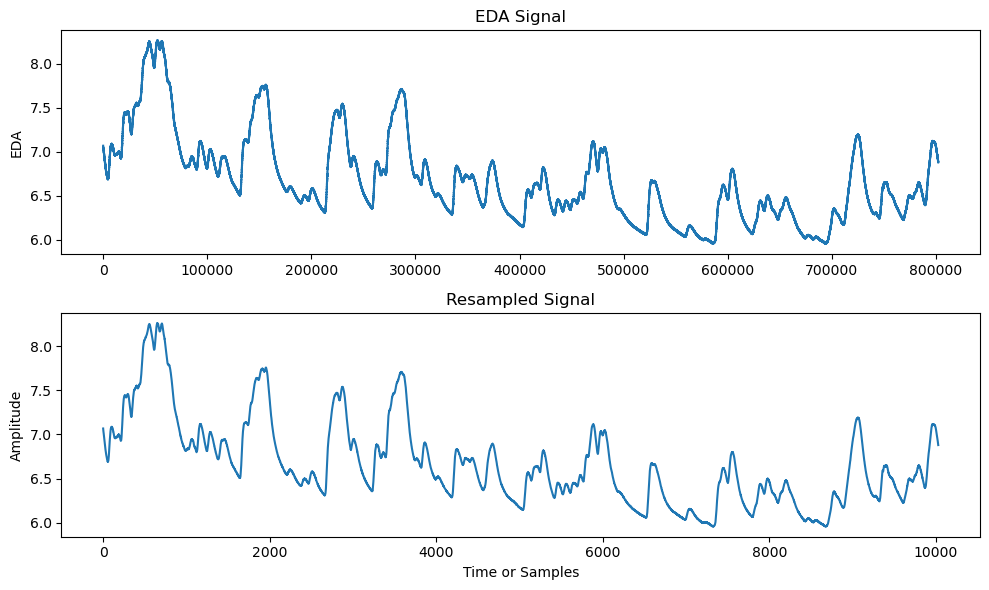

In [2]:
df = pd.read_csv('/Users/h/Documents/projects_local/sandbox/physiodata/sub-0081/ses-04/sub-0081_ses-04_task-cue_run-03-pain_recording-ppg-eda-trigger_physio.tsv', sep='\t')

df_metajson = '/Volumes/spacetop_projects_cue/analysis/physio/physio01_SCL_25s/sub-0081/ses-04/sub-0081_ses-04_run-03_runtype-pain_samplingrate-2000_onset.json'

with open(df_metajson, 'r') as file:
    df_meta = json.load(file)
    print(df_meta)

source_samplingrate=2000
dest_samplingrate=25
resamp = nk.signal_resample(
            df['physio_eda'].to_numpy(),  method='interpolation', sampling_rate=source_samplingrate, desired_sampling_rate=dest_samplingrate)

df.head()
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=False)  # Share the x-axis
axs[0].plot(df['physio_eda'])
axs[0].set_title('EDA Signal')
axs[0].set_ylabel('EDA')

# Plot `resamp` on the second subplot
axs[1].plot(resamp)
axs[1].set_title('Resampled Signal')
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Time or Samples')  
plt.tight_layout() 
plt.show()


In [3]:
from netneurotools import datasets as nntdata
# extract time series
from nilearn.maskers import NiftiMapsMasker,  NiftiLabelsMasker
from nilearn import datasets
fmri_fname = '/Users/h/Documents/projects_local/sandbox/fmriprep_bold/sub-0081/ses-04/func/sub-0081_ses-04_task-social_acq-mb8_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
confounds_fname = '/Users/h/Documents/projects_local/sandbox/fmriprep_bold/sub-0081/ses-04/func/sub-0081_ses-04_task-social_acq-mb8_run-3_desc-confounds_timeseries.tsv'
# schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=400, resolution_mm=2)
masker = NiftiLabelsMasker(labels_img=schaefer['maps'], 
                           labels=schaefer['labels']
                        #    standardize=True, 
                        #    high_pass=128,
                        #    t_r=0.46
                           )
# %%
# subset confounds
confounds = pd.read_csv(confounds_fname,sep='\t')
filter_col = [col for col in confounds if col.startswith("motion")]
default_csf_24dof = [
    "csf",
    "trans_x",
    "trans_x_derivative1",
    "trans_x_power2",
    "trans_x_derivative1_power2",
    "trans_y",
    "trans_y_derivative1",
    "trans_y_derivative1_power2",
    "trans_y_power2",
    "trans_z",
    "trans_z_derivative1",
    "trans_z_derivative1_power2",
    "trans_z_power2",
    "rot_x",
    "rot_x_derivative1",
    "rot_x_derivative1_power2",
    "rot_x_power2",
    "rot_y",
    "rot_y_derivative1",
    "rot_y_derivative1_power2",
    "rot_y_power2",
    "rot_z",
    "rot_z_derivative1",
    "rot_z_derivative1_power2",
    "rot_z_power2",
]
filter_col.extend(default_csf_24dof)
dummy = pd.DataFrame(np.eye(len(confounds))).loc[:, 0:5]
dummy.rename(
    columns={
        0: "dummy_00",
        1: "dummy_01",
        2: "dummy_02",
        3: "dummy_03",
        4: "dummy_04",
        5: "dummy_05"
    },
    inplace=True,
)
subset_confounds = pd.concat([confounds[filter_col], dummy], axis=1)

print("grabbed all the confounds and fmri data")
subset_confounds.head()
time_series = masker.fit_transform(fmri_fname,
                                confounds=subset_confounds.fillna(subset_confounds.median()))

grabbed all the confounds and fmri data


/Users/h/miniconda3/envs/physio/lib/python3.11/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


In [4]:
first_roi = time_series.T[0]
TR=0.46
fmri_samplingrate = 1/0.46
# resamp
physio_tr = nk.signal_resample(
            df['physio_eda'].to_numpy(),  method='interpolation', sampling_rate=source_samplingrate, desired_sampling_rate=fmri_samplingrate)

In [5]:
second_roi = time_series.T[1]

# outlier_bool = nk.find_outliers(second_roi, exclude=3, side='both', method='sd')

def winsorize_mad(data, threshold=3.5):
    wz = Winsorizer(capping_method='mad', tail='both', fold=threshold)
    winsorized_data = wz.fit_transform(data)
    return winsorized_data
fmri_outlier = winsorize_mad(second_roi.reshape(-1,1), threshold=7)
physio_outlier = winsorize_mad(physio_tr.reshape(-1,1), threshold=7)


<Axes: >

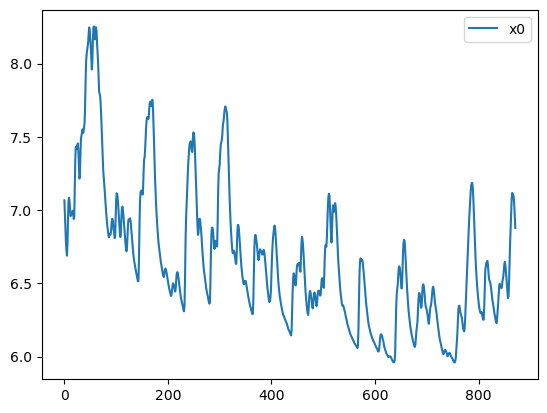

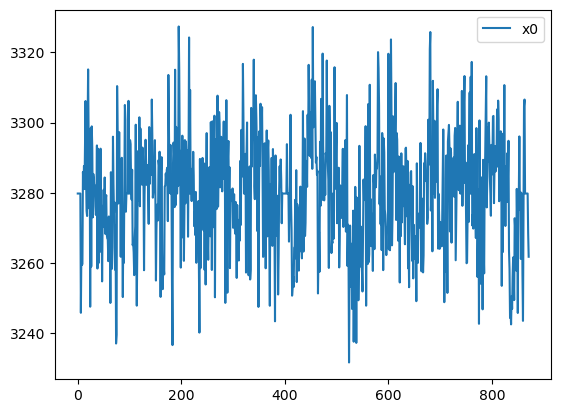

In [6]:
physio_outlier.plot()
fmri_outlier.plot()

In [7]:

# import matplotlib.pyplot as plt

# # Original data
# x = list(range(len(second_roi)))
# plt.scatter(x, second_roi, color='blue', label='Data')

# # column_values = second_roi
# outlier_data = [column_values[i] if outlier else None for i, outlier in enumerate(fmri_outlier)]
# plt.scatter(x, outlier_data, color='red', label='Outliers')
# plt.title('outlier validation: 1st iteration with participant "sub-0081')
# plt.legend()
# plt.show()

# # mask boolean array
# # first_roi_dropoutlier  = np.where(outlier_bool, first_roi, np.nan)
# second_roi_dropoutlier = np.where(outlier_bool, np.nan, second_roi)
# plt.plot(second_roi_dropoutlier)
# plt.show()

## drop outlier

In [8]:

# outlier_bool = nk.find_outliers(first_roi, exclude=3, side='both', method='sd')
# import matplotlib.pyplot as plt

# # Original data
# x = list(range(len(first_roi)))
# plt.scatter(x, first_roi, color='blue', label='Data')

# column_values = first_roi
# outlier_data = [column_values[i] if outlier else None for i, outlier in enumerate(outlier_bool)]
# plt.scatter(x, outlier_data, color='red', label='Outliers')
# plt.title('outlier validation: 1st iteration with participant "sub-0081')
# plt.legend()
# plt.show()

# # mask boolean array
# # first_roi_dropoutlier  = np.where(outlier_bool, first_roi, np.nan)
# first_roi_dropoutlier = np.where(outlier_bool, np.nan, first_roi)
# plt.plot(first_roi_dropoutlier)
# plt.show()

## ground truth cross corelation sandbox

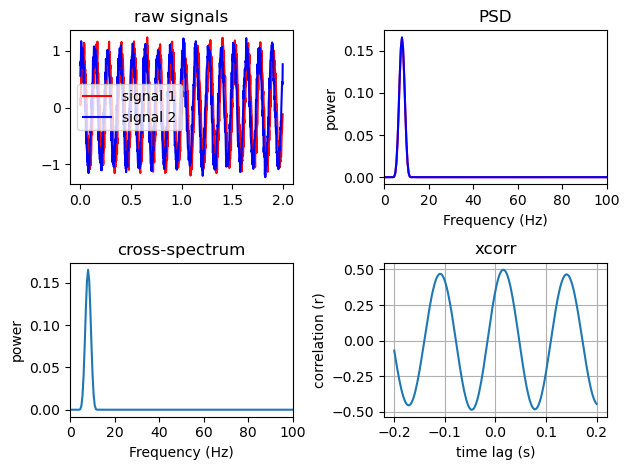

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, csd, correlate
from scipy.signal.windows import hann
# Generate signals
Fs = 500
tvec = np.arange(0, 2, 1/Fs)
data1 = np.sin(2 * np.pi * 8 * tvec) + 0.1 * np.random.randn(len(tvec))
data2 = np.sin(2 * np.pi * 8 * tvec + np.pi/4) + 0.1 * np.random.randn(len(tvec))

# Plot raw signals
plt.figure()
plt.subplot(221)
plt.plot(tvec, data1, 'r', tvec, data2, 'b')
plt.legend(['signal 1', 'signal 2'])
plt.title('raw signals')

# Compute and plot PSD
window = hann(250)
noverlap = 125
nfft = len(data1)

f, Pxx = welch(data1, Fs, window=window, noverlap=noverlap, nfft=nfft)
_, Pyy = welch(data2, Fs, window=window, noverlap=noverlap, nfft=nfft)

plt.subplot(222)
plt.plot(f, np.abs(Pxx), 'r', f, np.abs(Pyy), 'b')
plt.xlim([0, 100])
plt.xlabel('Frequency (Hz)')
plt.ylabel('power')
plt.title('PSD')

# Compute and plot cross-spectrum
f, Pxy = csd(data1, data2, Fs, window=window, noverlap=noverlap, nfft=nfft)

plt.subplot(223)
plt.plot(f, np.abs(Pxy))
plt.xlim([0, 100])
plt.xlabel('Frequency (Hz)')
plt.ylabel('power')
plt.title('cross-spectrum')

# Compute and plot cross-correlation
maxlags = 100
acf = correlate(data1, data2, mode='full', method='auto')
acf /= len(data1)  # Normalizing
lags = np.arange(-maxlags, maxlags + 1) * (1./Fs)

plt.subplot(224)
plt.plot(lags[len(lags)//2-maxlags:len(lags)//2+maxlags+1], acf[len(acf)//2-maxlags:len(acf)//2+maxlags+1])
plt.grid(True)
plt.xlabel('time lag (s)')
plt.ylabel('correlation (r)')
plt.title('xcorr')

# Show the figure
plt.tight_layout()
plt.show()

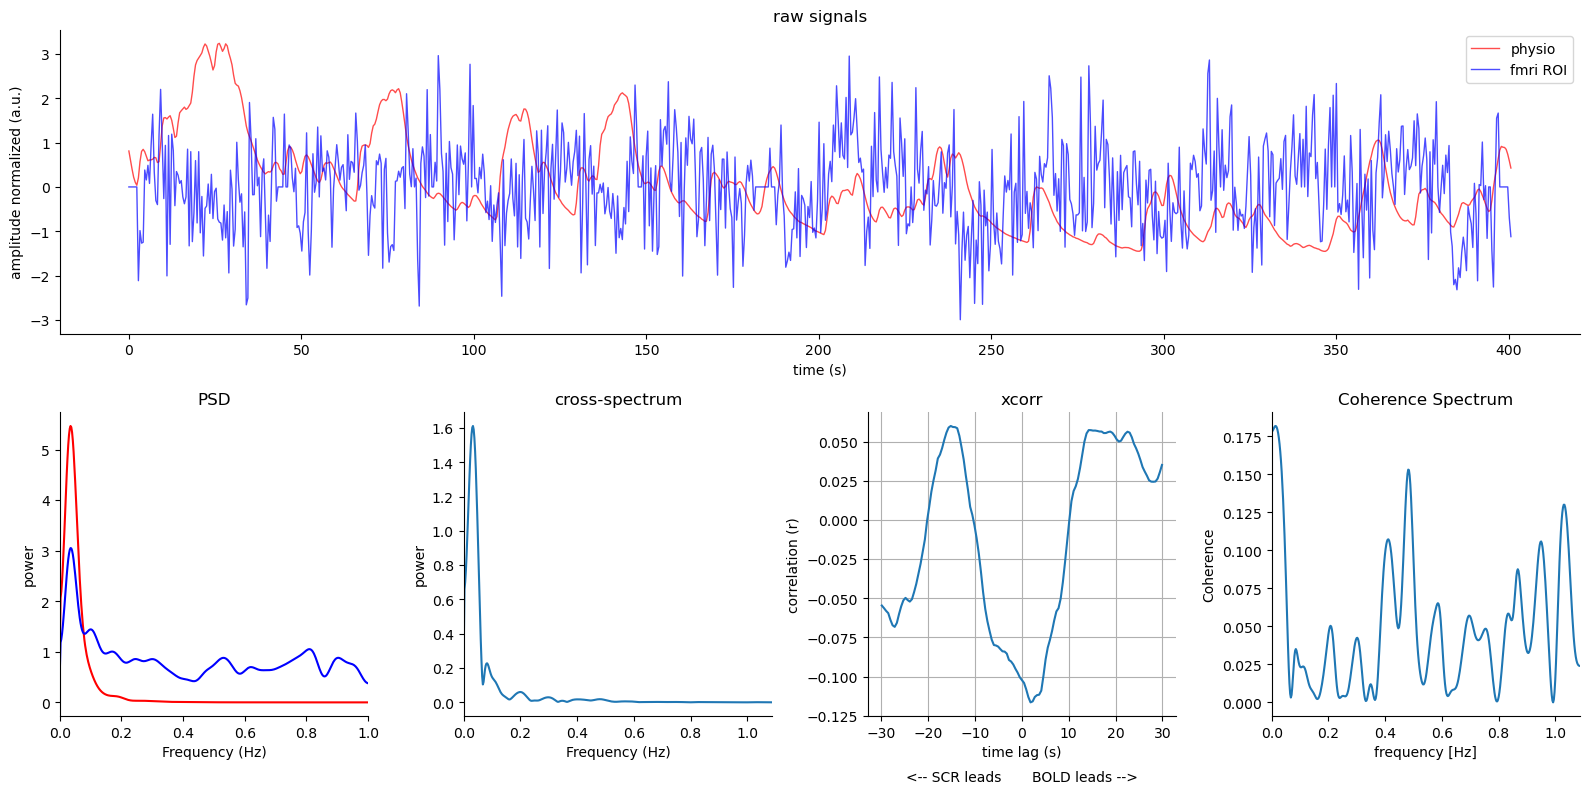

max value: 0.1164576815287703, max lag: 1.84


In [41]:
# modify this for physio and fmri _______________
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, csd, correlate, coherence
from scipy.signal.windows import hann
import matplotlib.gridspec as gridspec
import seaborn as sns
# Generate signals
TR=0.46
Fs = 1/TR #1/TR
# clean up data
physio_standardized = (physio_outlier - np.nanmean(physio_outlier) )/ np.nanstd(physio_outlier)
fmri_standardized = (fmri_outlier - np.nanmean(fmri_outlier)) / np.nanstd(fmri_outlier)
tvec = np.arange(0, len(physio_standardized) / Fs, 1/Fs)
data1_centered = physio_standardized - np.nanmean(physio_standardized)
data2_centered = fmri_standardized - np.nanmean(fmri_standardized)#fmri_standardizednp.nan_to_num(np.mean(fmri_standardized))
# Calculate the mean of non-NaN values
# mean_data1 = np.nanmean(data1)
# mean_data2 = np.nanmean(data2)
from scipy.interpolate import interp1d
# Replace NaN values with the computed mean
# data1 = np.where(np.isnan(data1), mean_data1, data1)
# data2 = np.where(np.isnan(data2), mean_data2, data2)
def interpolate_data(data):
    time_points = np.arange(len(data))
    valid = ~np.isnan(data)  # Mask of valid (non-NaN) data points
    interp_func = interp1d(time_points[valid], data[valid], kind='linear', fill_value="extrapolate")
    return interp_func(time_points)
# Interpolate missing values
data1 = interpolate_data(data1_centered.values.flatten())
data2 = interpolate_data(data2_centered.values.flatten())





fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, :]) # Wide subplot on row 1
ax2 = fig.add_subplot(gs[1, 0]) # Subplot 1 on row 2
ax3 = fig.add_subplot(gs[1, 1]) # Subplot 2 on row 2
ax4 = fig.add_subplot(gs[1, 2]) # Subplot 3 on row 2
ax5 = fig.add_subplot(gs[1, 3]) # Subplot 3 on row 2
# plt 1: Plot raw signals ______________________________
ax1.plot(tvec, data1, 'r', linewidth=1, alpha=0.7)
ax1.plot(tvec, data2, 'b', linewidth=1, alpha=0.7)
ax1.legend(['physio', f'fmri ROI'])
ax1.set_xlabel('time (s)')
ax1.set_ylabel('amplitude normalized (a.u.)')
ax1.set_title('raw signals')

# plt 2: Compute and plot PSD ______________________________
window_size = 30
ws = int(Fs * window_size)
window = hann(ws)
noverlap = ws // 2
nfft = len(tvec)

f, Pxx = welch(data1, Fs, window=window, noverlap=noverlap, nfft=nfft)
_, Pyy = welch(data2, Fs, window=window, noverlap=noverlap, nfft=nfft)

ax2.plot(f, np.abs(Pxx), 'r', f, np.abs(Pyy), 'b')
ax2.set_xlim([0, 1])
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('power')
ax2.set_title('PSD')

# plot 3: Compute and plot cross-spectrum
f, Pxy = csd(data1, data2, Fs, window=window, noverlap=noverlap, nfft=nfft)

# plt.subplot(223)
ax3.plot(f, np.abs(Pxy))
ax3.set_xlim([0, Fs/2]) # Nyquist frequency is the upper bound
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('power')
ax3.set_title('cross-spectrum')

# plot4: Compute and plot cross-correlation
maxlags = int(Fs * window_size)
acf = correlate(data1, data2, mode='full', method='direct')
# crossSD = abs(Pxy)**2/(Pxx*Pyy)
norm_factor = np.sqrt(np.sum(data1**2) * np.sum(data2**2))
acf_normalized = acf / norm_factor
# Calculate auto-correlations at lag 0
# auto_corr_data1 = np.sum(data1 ** 2)
# auto_corr_data2 = np.sum(data2 ** 2)

# Normalize cross-correlation
# acf_normalized = acf / np.sqrt(auto_corr_data1 * auto_corr_data2)

# acf /= len(data1)  # Normalizing
lags = np.arange(-maxlags, maxlags + 1) * (1./Fs)

# plt.subplot(224)
ax4.plot(lags[len(lags)//2-maxlags:len(lags)//2+maxlags+1], acf_normalized[len(acf_normalized)//2-maxlags:len(acf_normalized)//2+maxlags+1])

# ax4.plot(lags[len(lags)//2-maxlags:len(lags)//2+maxlags+1], acf[len(acf)//2-maxlags:len(acf)//2+maxlags+1])
ax4.grid(True)
ax4.set_xlabel('time lag (s)')
ax4.set_ylabel('correlation (r)')
ax4.set_title('xcorr')
ax4.text(0.5, -0.2, '<-- SCR leads       BOLD leads -->', ha='center', va='center', transform=ax4.transAxes)


# plot 5

f_coh, Cxy = coherence(data1, data2, Fs, window=hann(ws), noverlap=noverlap, nfft=nfft)
ax5.plot(f_coh, Cxy)
ax5.set_xlim([0, Fs/2])  # Limit to Nyquist frequency

ax5.set_xlabel('frequency [Hz]')
ax5.set_ylabel('Coherence')
ax5.set_title('Coherence Spectrum')
# Show the figure
plt.tight_layout()
sns.despine()
plt.show()


acf_sliced = acf_normalized[len(acf_normalized)//2-maxlags:len(acf_normalized)//2+maxlags+1]
lags_sliced = lags[len(lags)//2-maxlags:len(lags)//2+maxlags+1]
absolute_values = [abs(number) for number in acf_sliced]  # Convert all numbers to their absolute values
# absolute_max_value = max(absolute_values) 
max_acf_value = np.max(absolute_values)
max_acf_index = np.argmax(absolute_values)
max_lag_time = lags_sliced[max_acf_index]
print(f"max value: {max_acf_value}, max lag: {max_lag_time}")

## try with a different window

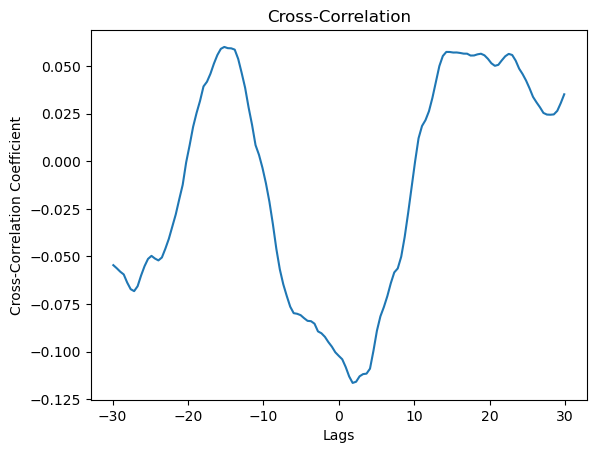

0.11645768152877033 4


In [11]:
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt

# Assuming data1 and data2 are your data sequences

# Calculate the cross-correlation and lags
maxlags = int(Fs * 30)
ccf = correlate(data1 - np.mean(data1), data2 - np.mean(data2), mode='full', method='auto')
lags = np.arange(-len(data1) + 1, len(data2))

# Normalize the cross-correlation
norm_factor = np.sqrt(np.sum((data1 - np.mean(data1))**2) * np.sum((data2 - np.mean(data2))**2))
ccf /= norm_factor

# Limit the lags and cross-correlation to -max_lags to max_lags
max_lags_index = np.where((lags >= -maxlags) & (lags <= maxlags))
ccf = ccf[max_lags_index]
lags = lags[max_lags_index]
convert_lags = lags*(1./Fs); #convert samples to time

# Plot the cross-correlation function
plt.figure()
plt.plot(convert_lags, ccf)
plt.xlabel('Lags')
plt.ylabel('Cross-Correlation Coefficient')
plt.title('Cross-Correlation')
plt.show()

acf_sliced = ccf[len(ccf)//2-maxlags:len(ccf)//2+maxlags+1]
lags_sliced = lags[len(lags)//2-maxlags:len(lags)//2+maxlags+1]
absolute_values = [abs(number) for number in acf_sliced] 
max_acf_value = np.max(absolute_values)
max_acf_index = np.argmax(absolute_values)
max_lag_time = lags_sliced[max_acf_index]
print(max_acf_value, max_lag_time)

# TODO:
* run this for each ROI
* save the max corr and lag values in a pandas dataframe
* extract metadata sub/ses/run
* later, plot this in the brain for every parcel

<!-- Another way to calculate coherence spectrum
abs(Pxy) ** 2 / (Pxx*Pxy) -->

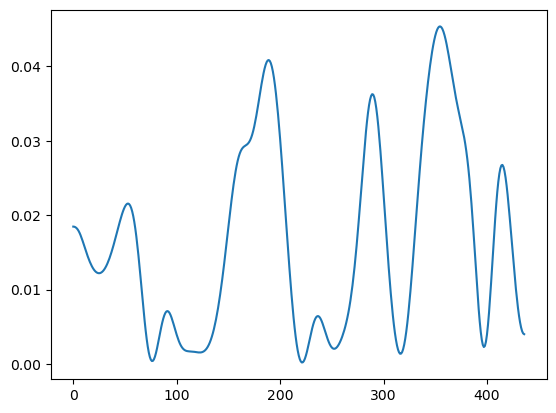

In [12]:
crossSD = abs(Pxy)**2/(Pxx*Pyy)
# ax5.plot(f_coh, crossSD)
plt.plot( crossSD)
# plt.xlim([0, Fs/2])
plt.show()

In [13]:
time_series.shape

(872, 400)

In [51]:
converted_df_meta

{'event_cue': {'start': [16.63695652173913,
   112.94021739130434,
   201.6336956521739,
   267.2869565217391,
   327.95108695652175,
   408.5945652173913,
   473.37282608695654,
   534.2423913043478,
   602.5065217391304,
   672.2858695652174,
   736.4173913043478,
   807.0684782608696],
  'stop': [18.768478260869564,
   115.07282608695652,
   203.76847826086956,
   269.420652173913,
   330.0739130434783,
   410.72391304347826,
   475.50652173913045,
   536.3760869565217,
   604.6369565217391,
   674.4195652173913,
   738.55,
   809.2021739130435]},
 'event_expectrating': {'start': [20.79891304347826,
   118.59239130434783,
   207.93804347826088,
   274.4576086956522,
   331.8608695652174,
   413.1586956521739,
   477.93695652173915,
   539.6760869565218,
   609.2478260869565,
   677.283695652174,
   743.1532608695652,
   812.0760869565217],
  'stop': [25.007608695652173,
   123.08804347826087,
   212.7586956521739,
   280.83478260869566,
   338.4217391304348,
   418.66847826086956,
 

# Suggestions from Matt
* deconvolve fMRI signal
* snip out xcorr value for each parcel
* plot average across participants

In [18]:
import pandas as pd
import numpy as np

# Original and target sampling rates ___________________________________________
# source_samplingrate = 2000  # Hz
# fmri_samplingrate = 1 / 0.46  # Hz

# Calculate conversion factor
conversion_factor = source_samplingrate / fmri_samplingrate


converted_df_meta = {}
for event_type, times in df_meta.items():
    converted_df_meta[event_type] = {}
    for key, value in times.items():
        converted_df_meta[event_type][key] = [x / conversion_factor for x in value]

converted_df_meta
# converted_df_meta['event_stimuli'] information
event_stimuli_start = converted_df_meta['event_stimuli']['start']
event_stimuli_stop =  converted_df_meta['event_stimuli']['stop']

# Sampling rate information and padding calculation
sampling_rate = 1 / 0.46  # Hz
padding_seconds = 5  # seconds
padding_samples = padding_seconds * sampling_rate  # Convert seconds to samples based on sampling rate
beh_meta = pd.read_csv('/Volumes/spacetop_projects_cue/analysis/physio/physio01_SCL_25s/sub-0081/ses-04/sub-0081_ses-04_run-03_runtype-pain_epochstart--3_epochend-20_physio-scl.csv')
beh_meta.head()

# Extract signals with padding and categorize by cue type

physio_stim = []
fmri_stim = []


for i, (start, stop, cue_type) in enumerate(zip(event_stimuli_start, event_stimuli_stop)):
    start_index = max(0, int(start) - padding_samples)
    stop_index = min(len(data1_centered) - 1, np.round(stop)  + padding_samples)
    physio_segment = data1_centered.loc[int(start_index):int(stop_index), 'x0']
    fmri_segment = data2_centered.loc[int(start_index):int(stop_index), 'x0']
    physio_stim.append(physio_segment)
    fmri_stim.append(fmri_segment)

# For demonstration, the number of segments extracted for each cue type is shown
len(physio_stim), len(fmri_stim)



(12, 12)

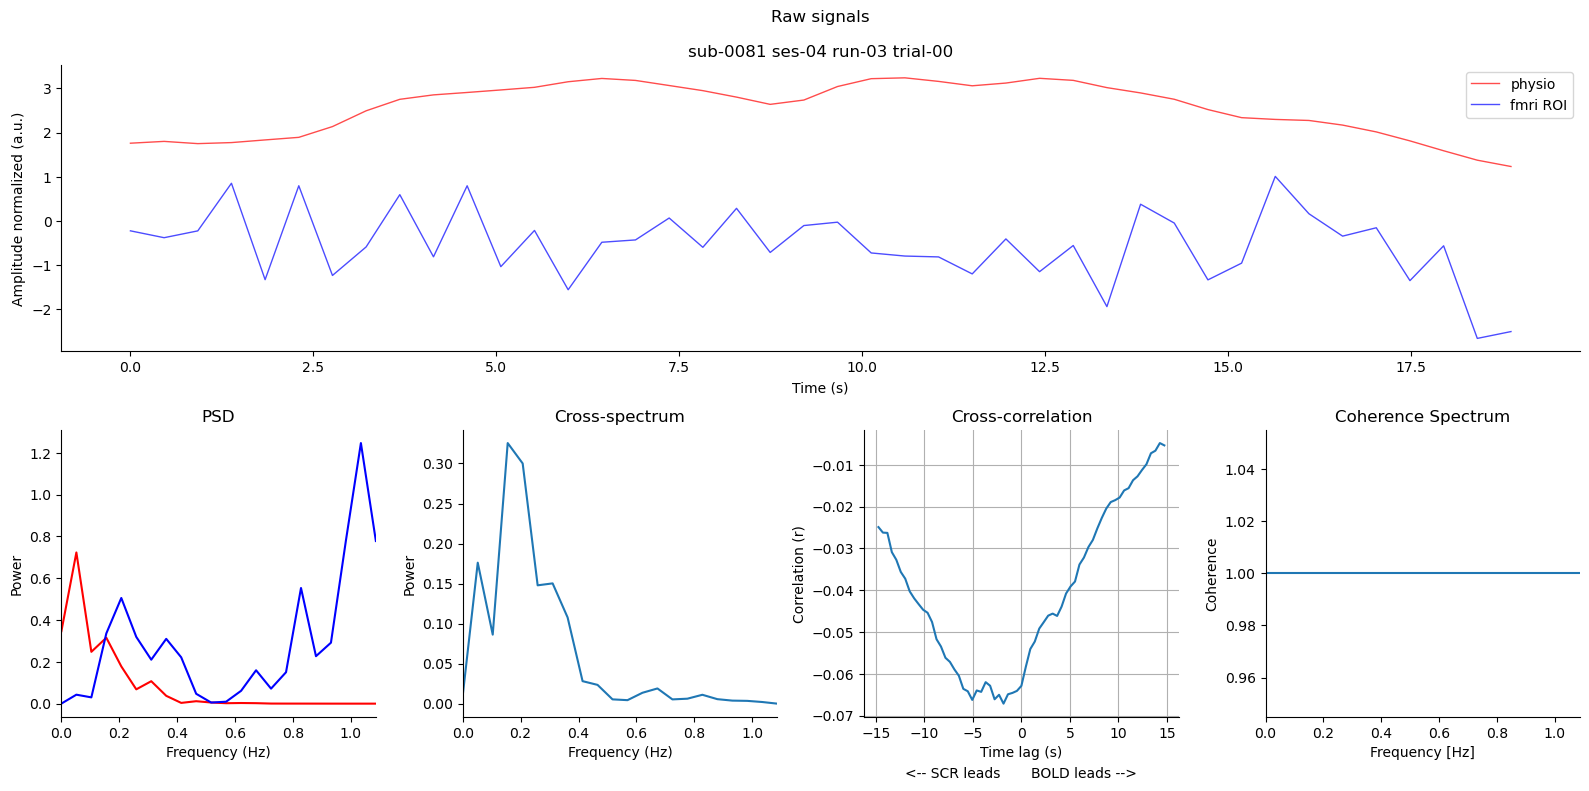

max value: 0.0671500573987605, max lag: -1.84


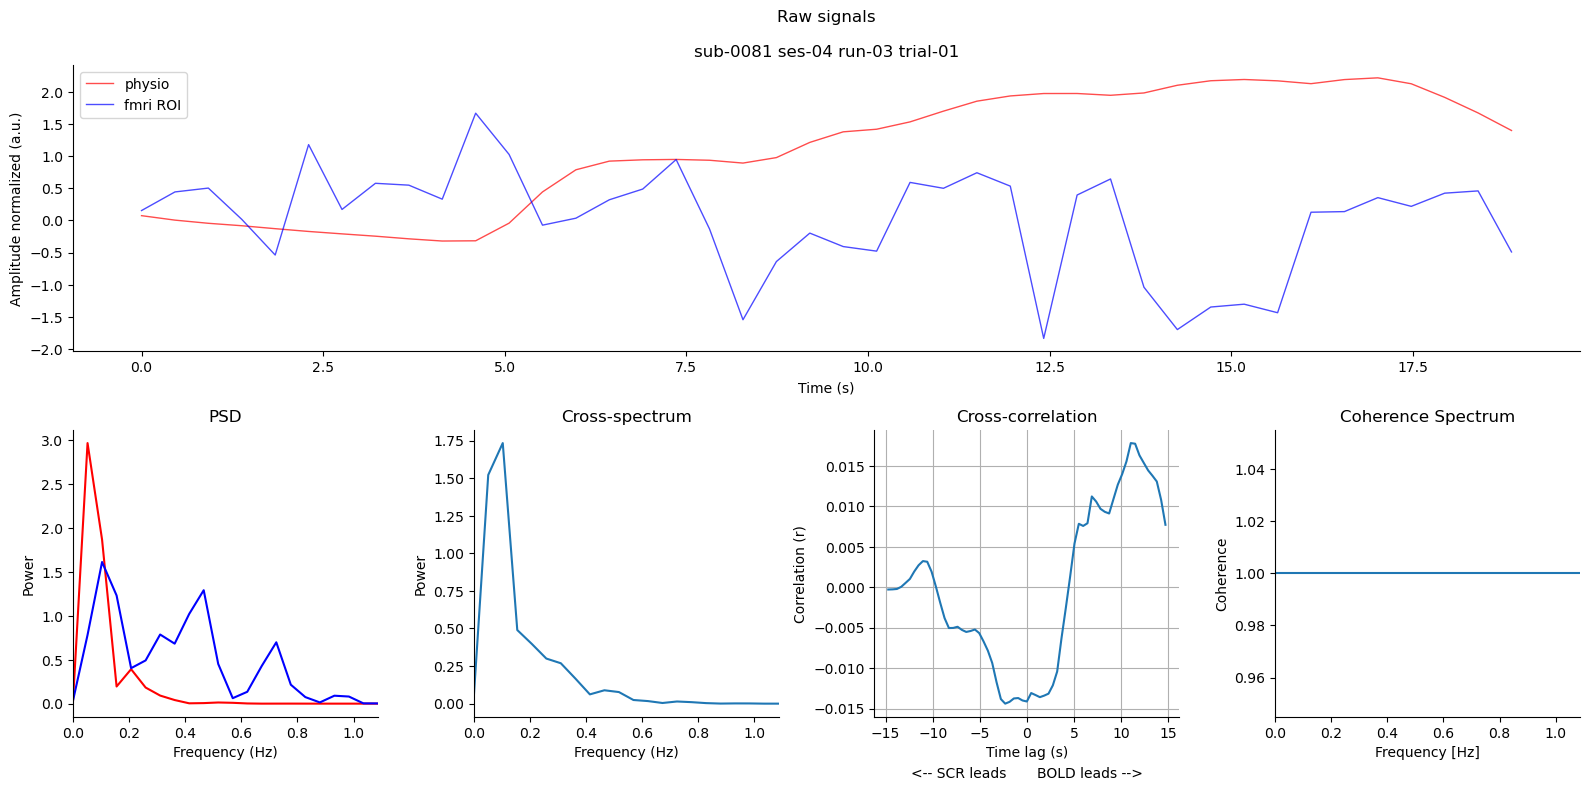

max value: 0.017803812490686955, max lag: 11.040000000000001


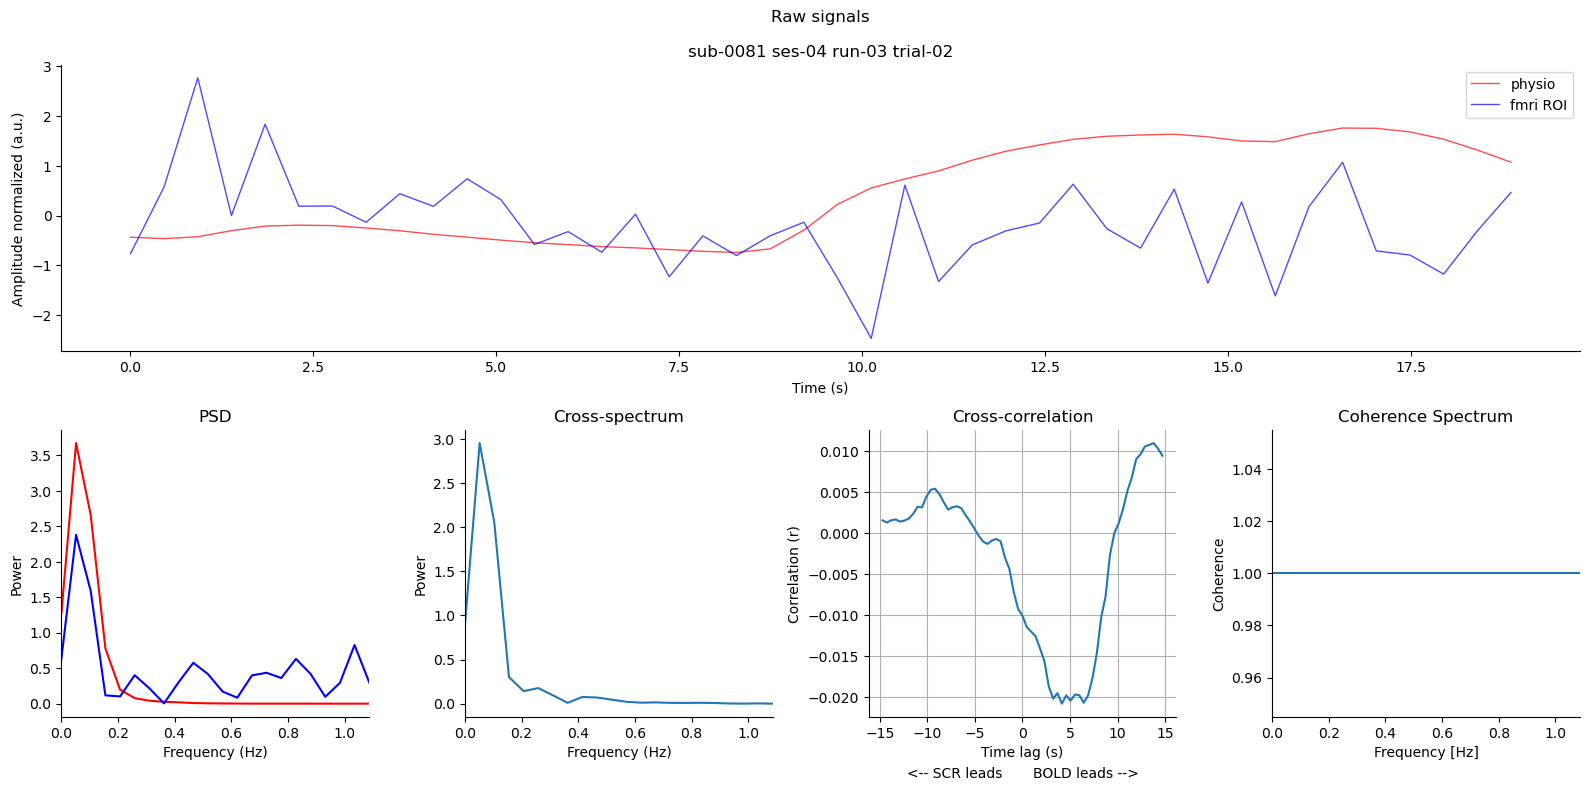

max value: 0.02075778980105147, max lag: 4.140000000000001


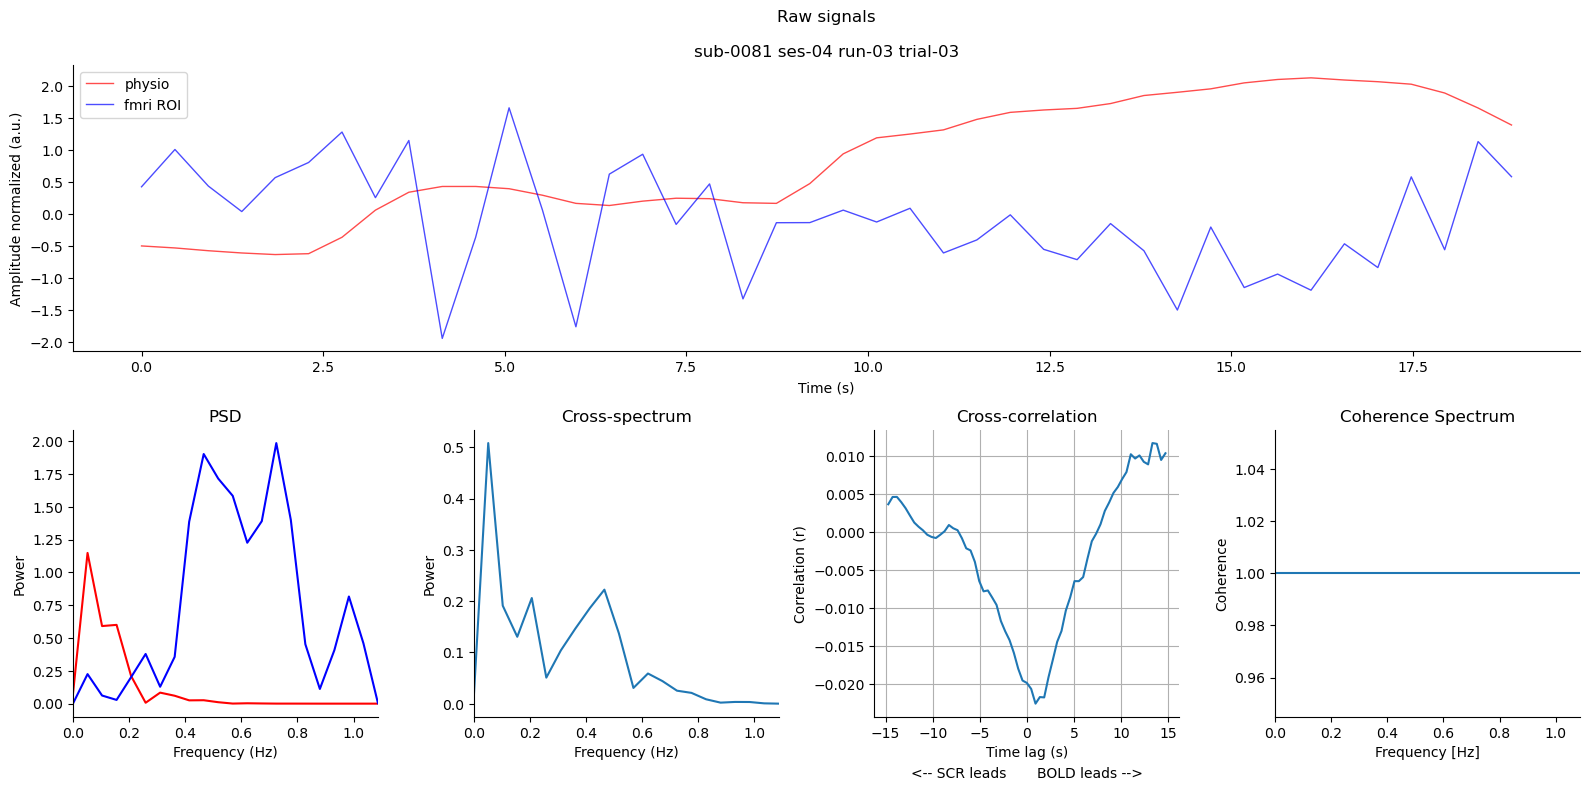

max value: 0.022512019287326056, max lag: 0.92


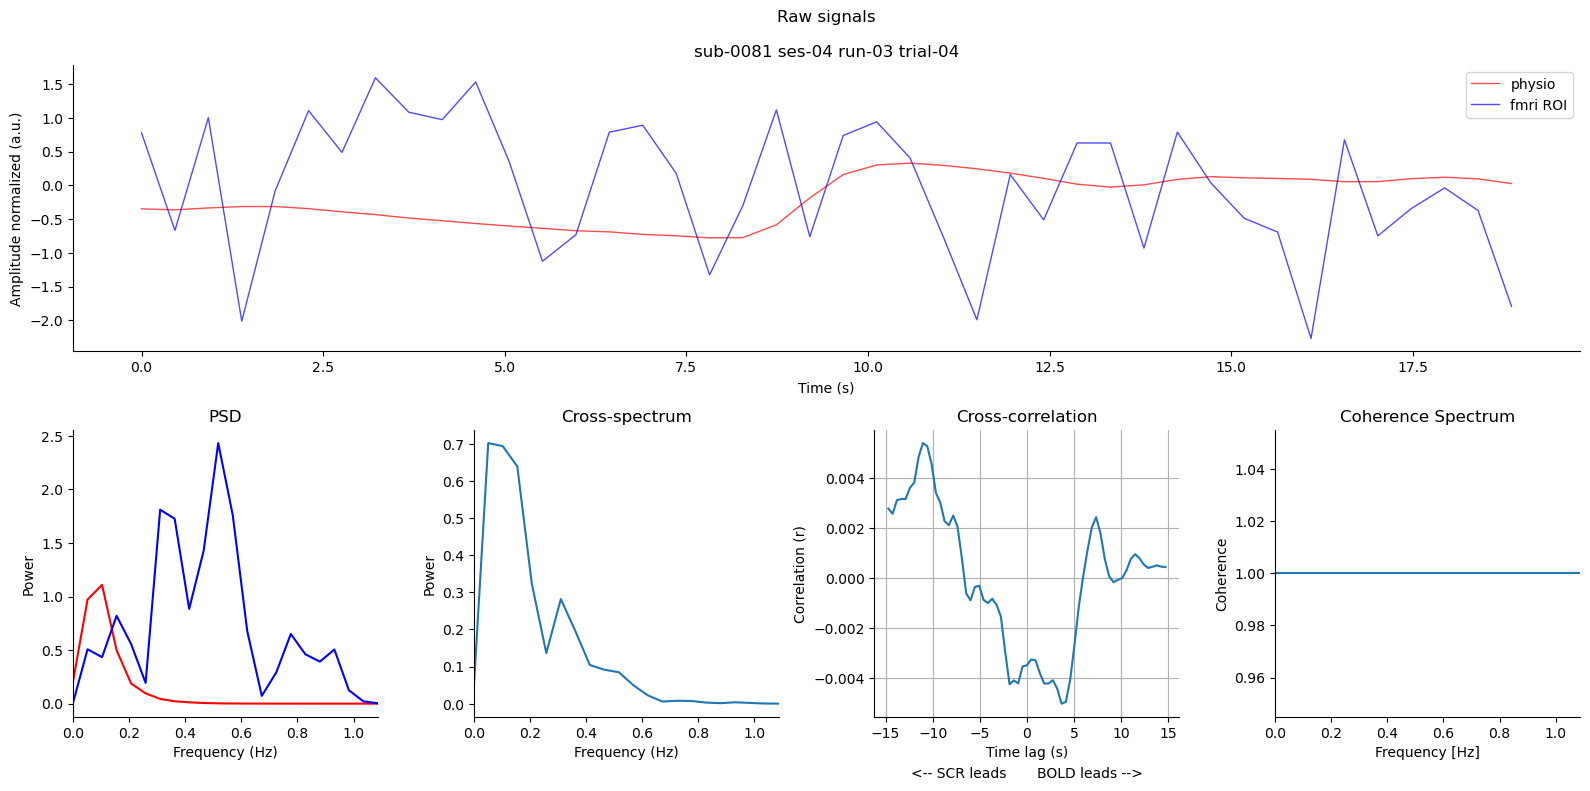

max value: 0.0053950328973036326, max lag: -11.040000000000001


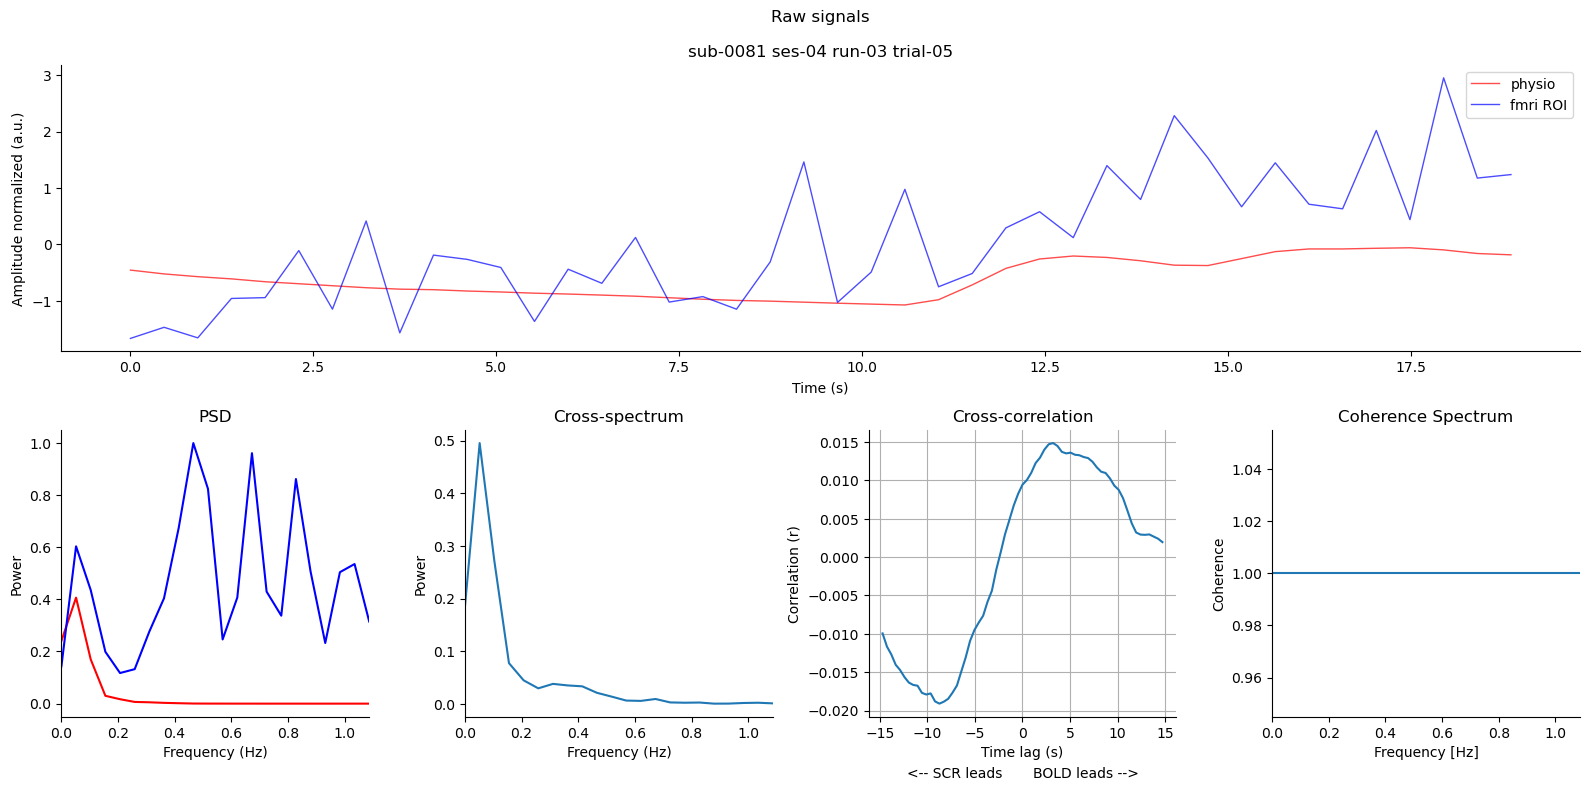

max value: 0.019095148044589297, max lag: -8.74


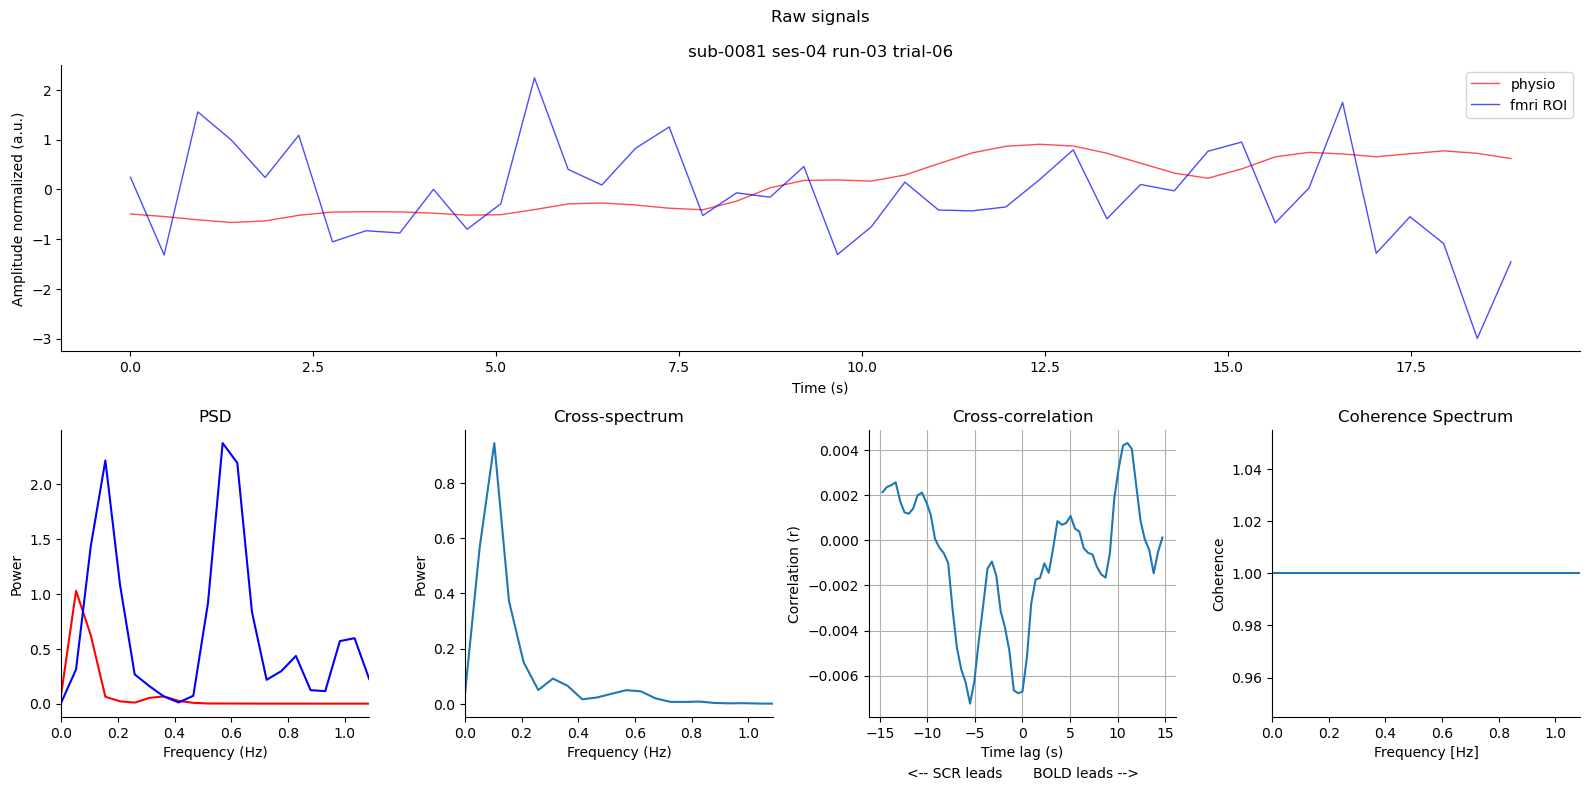

max value: 0.007244626660561548, max lag: -5.5200000000000005


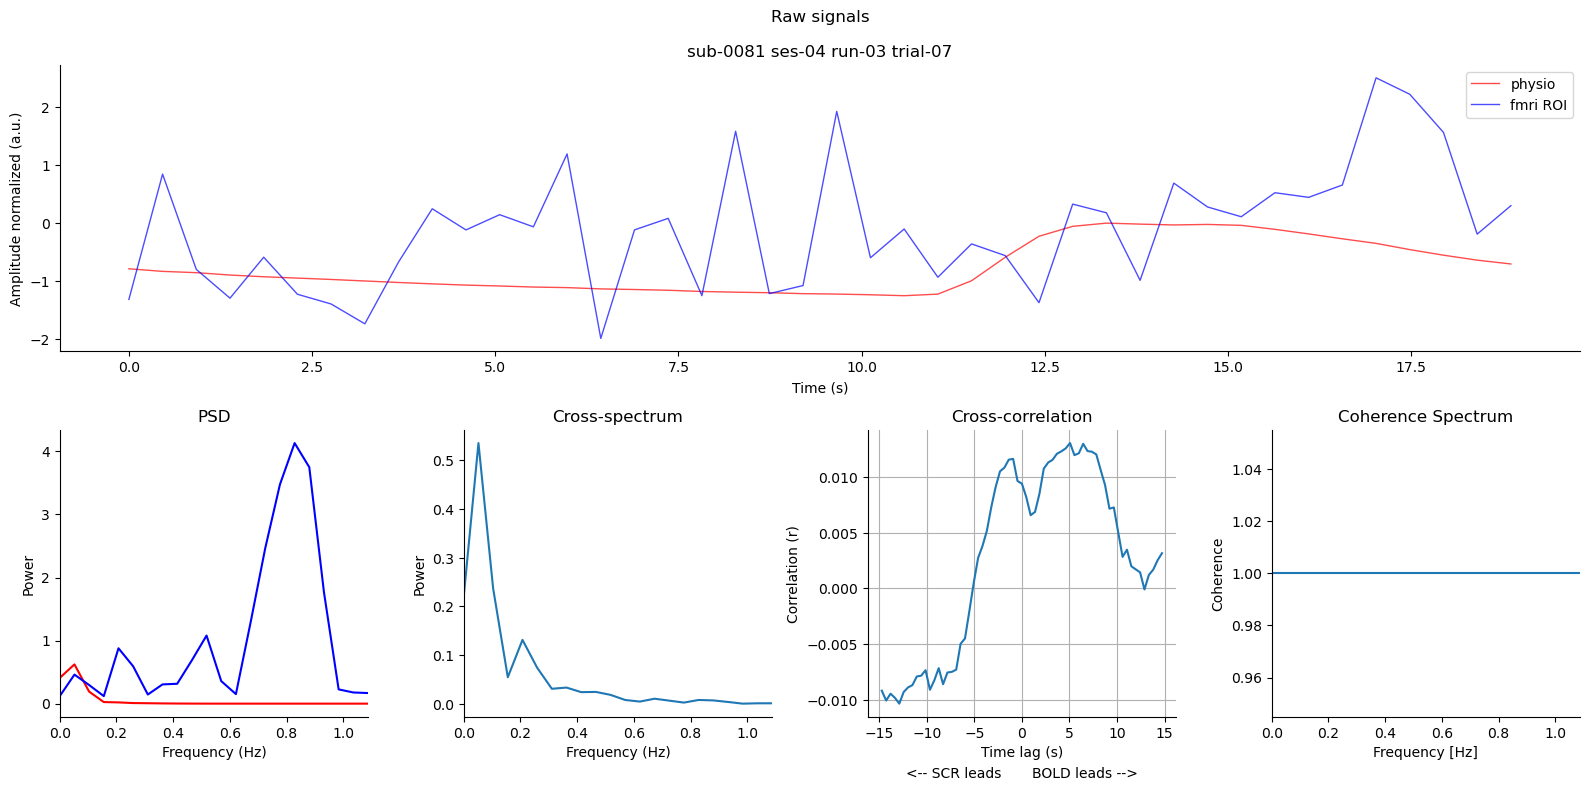

max value: 0.013047449109609588, max lag: 5.0600000000000005


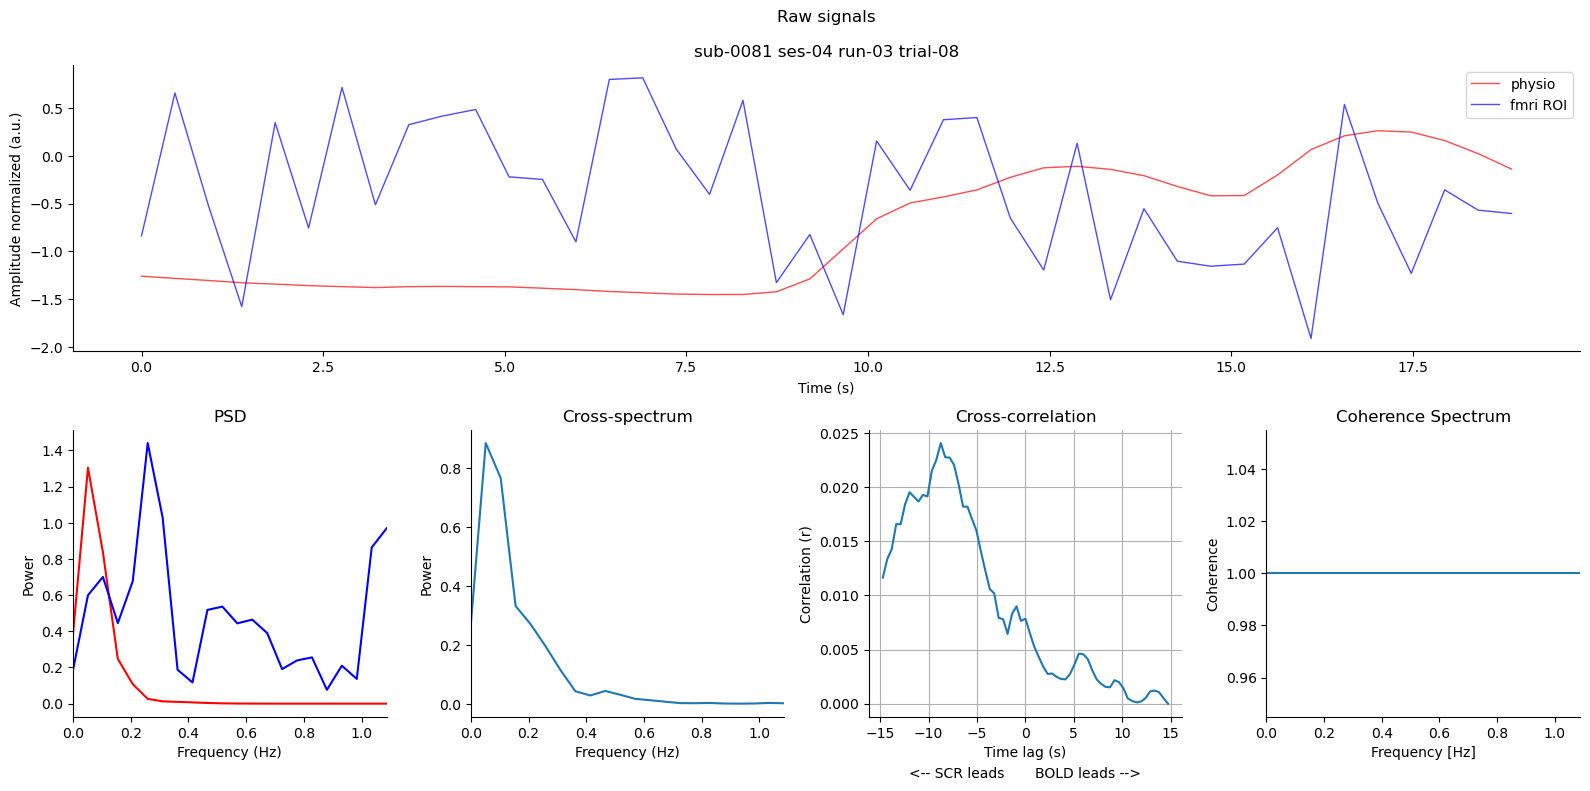

max value: 0.024075332887407642, max lag: -8.74


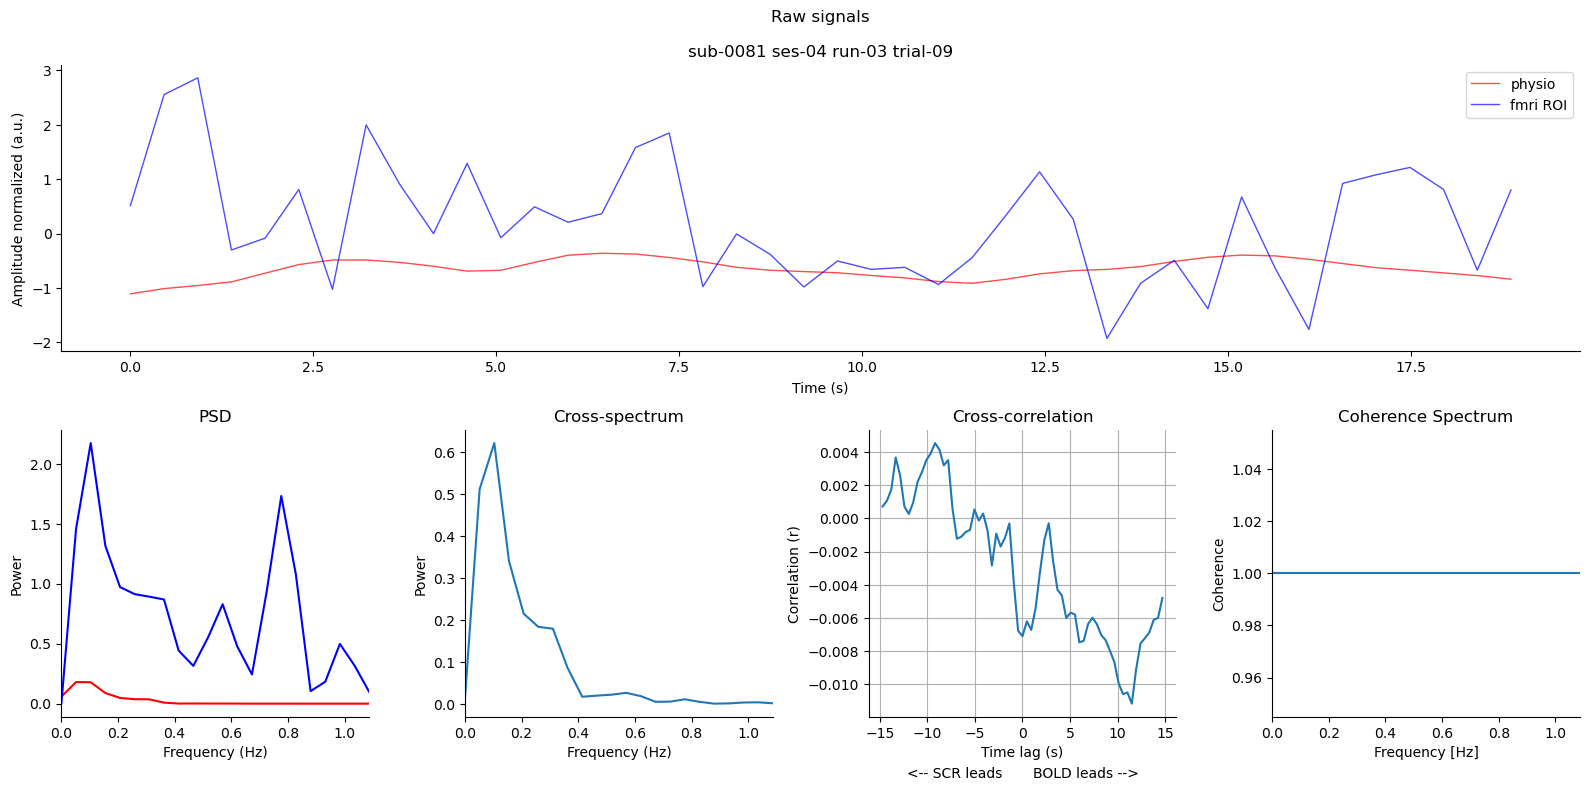

max value: 0.011166000097155078, max lag: 11.5


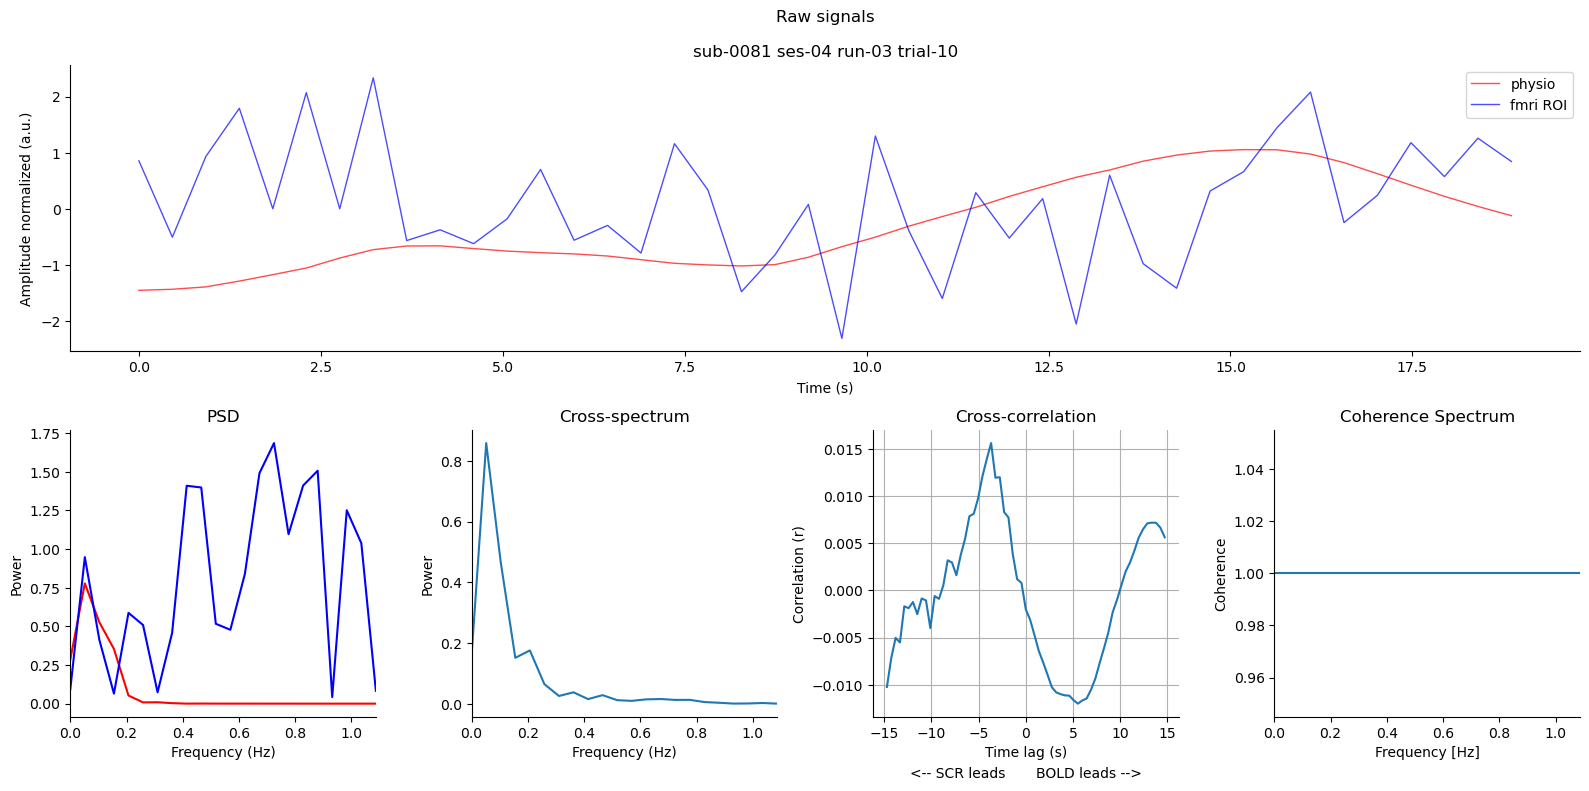

max value: 0.01559994563568989, max lag: -3.68


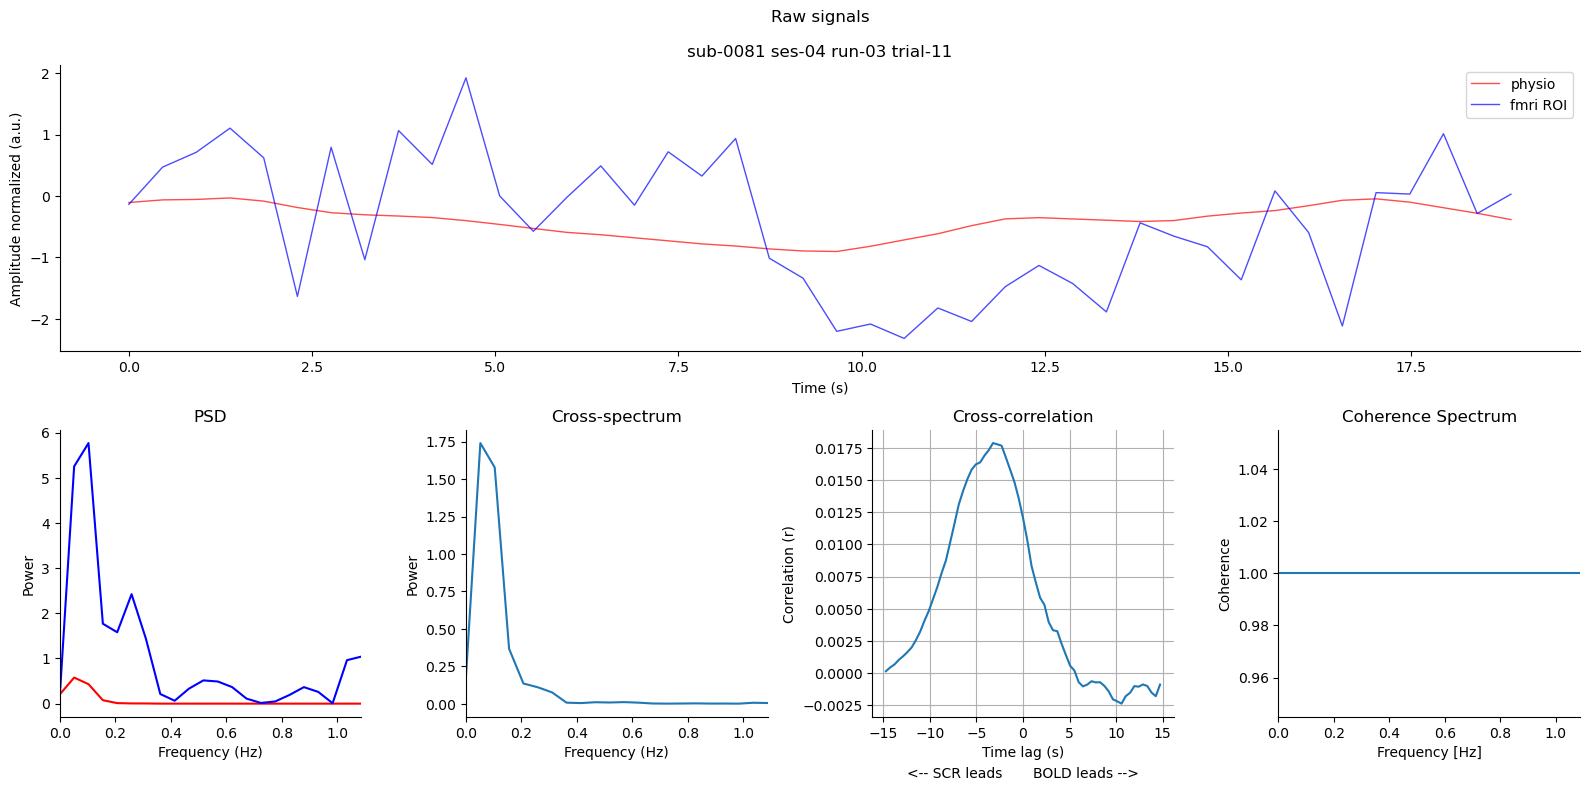

max value: 0.017883729087826695, max lag: -3.22


In [50]:
# 2. Extract bids info
import re
physio_fname = '/Users/h/Documents/projects_local/sandbox/physiodata/sub-0081/ses-04/sub-0081_ses-04_task-cue_run-03-pain_recording-ppg-eda-trigger_physio.tsv'
matches = re.search(r"sub-(\d+)/ses-(\d+)/.*_run-(\d+)-", physio_fname)
if matches:
    sub = f"sub-{matches.group(1)}"
    ses = f"ses-{matches.group(2)}"
    run = f"run-{matches.group(3)}"
else:
    sub, ses, run = None, None, None


trialwise_xcorr = pd.DataFrame(index=range(len(physio_stim)), columns=['sub', 'ses', 'run', 'trial', 'Maximum Correlation Value', 'Time Lag (s)'])


for i in np.arange(len(physio_stim)):
    fig = plt.figure(figsize=(16, 8))
    gs = gridspec.GridSpec(2, 4, figure=fig)
    ax1 = fig.add_subplot(gs[0, :]) # Wide subplot on row 1
    ax2 = fig.add_subplot(gs[1, 0]) # Subplot 1 on row 2
    ax3 = fig.add_subplot(gs[1, 1]) # Subplot 2 on row 2
    ax4 = fig.add_subplot(gs[1, 2]) # Subplot 3 on row 2
    ax5 = fig.add_subplot(gs[1, 3]) # Subplot 3 on row 2

    physio_low_cue_mean = physio_stim[i].values #np.mean(np.vstack(physio_stim[i]), axis=0).T
    fmri_low_cue_mean = fmri_stim[i].values #np.mean(np.vstack(fmri_stim[i]), axis=0).T
    signal_length = len(physio_low_cue_mean)
    time_vector = np.arange(signal_length) / Fs

    # plt 1: Plot raw signals ______________________________
    ax1.plot(time_vector, physio_low_cue_mean, 'r', linewidth=1, alpha=0.7)
    ax1.plot(time_vector, fmri_low_cue_mean, 'b', linewidth=1, alpha=0.7)
    ax1.legend(['physio', f'fmri ROI'])
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude normalized (a.u.)')
    ax1.set_title(f'Raw signals\n\n{sub} {ses} {run} trial-{i:02d}')

    # Check the length of your signal
    window_size = 15
    ws = int(Fs * window_size) 
    window = hann(ws)
    noverlap = ws // 2
    nfft = signal_length

    f, Pxx = welch(np.array(physio_low_cue_mean), Fs, window=window, noverlap=noverlap, nfft=nfft)
    _, Pyy = welch(np.array(fmri_low_cue_mean), Fs, window=window, noverlap=noverlap, nfft=nfft)


    ax2.plot(f, np.abs(Pxx), 'r', f, np.abs(Pyy), 'b')
    ax2.set_xlim([0, Fs/2])


    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Power')
    ax2.set_title('PSD')



    # plot 3: Compute and plot cross-spectrum
    f, Pxy = csd(np.array(physio_low_cue_mean), np.array(fmri_low_cue_mean), Fs, window=window, noverlap=noverlap, nfft=nfft)

    # plt.subplot(223)
    ax3.plot(f, np.abs(Pxy))
    ax3.set_xlim([0, Fs/2]) # Nyquist frequency is the upper bound
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Power')
    ax3.set_title('Cross-spectrum')

    # plot4: Compute and plot cross-correlation
    maxlags = int(Fs * window_size)
    acf = correlate(np.array(physio_low_cue_mean), np.array(fmri_low_cue_mean), mode='full', method='direct')
    # crossSD = abs(Pxy)**2/(Pxx*Pyy)
    norm_factor = np.sqrt(np.sum(data1**2) * np.sum(data2**2))
    acf_normalized = acf / norm_factor
    # Calculate auto-correlations at lag 0
    # auto_corr_data1 = np.sum(data1 ** 2)
    # auto_corr_data2 = np.sum(data2 ** 2)

    # Normalize cross-correlation
    # acf_normalized = acf / np.sqrt(auto_corr_data1 * auto_corr_data2)

    # acf /= len(data1)  # Normalizing
    lags = np.arange(-maxlags, maxlags + 1) * (1./Fs)

    # plt.subplot(224)
    ax4.plot(lags[len(lags)//2-maxlags:len(lags)//2+maxlags+1], acf_normalized[len(acf_normalized)//2-maxlags:len(acf_normalized)//2+maxlags+1])

    # ax4.plot(lags[len(lags)//2-maxlags:len(lags)//2+maxlags+1], acf[len(acf)//2-maxlags:len(acf)//2+maxlags+1])
    ax4.grid(True)
    ax4.set_xlabel('Time lag (s)')
    ax4.set_ylabel('Correlation (r)')
    ax4.set_title('Cross-correlation')
    ax4.text(0.5, -0.2, '<-- SCR leads       BOLD leads -->', ha='center', va='center', transform=ax4.transAxes)


    # plot 5

    f_coh, Cxy = coherence(np.array(physio_low_cue_mean), np.array(fmri_low_cue_mean), Fs, window=hann(ws), noverlap=noverlap, nfft=nfft)
    ax5.plot(f_coh, Cxy)
    ax5.set_xlim([0, Fs/2])  # Limit to Nyquist frequency

    ax5.set_xlabel('Frequency [Hz]')
    ax5.set_ylabel('Coherence')
    ax5.set_title(f'Coherence Spectrum')
    # Show the figure
    plt.tight_layout()
    sns.despine()
    plt.show()
    # plt.close()

    # trialwise_xcorr = 
    acf_sliced = acf_normalized[len(acf_normalized)//2-maxlags:len(acf_normalized)//2+maxlags+1]
    lags_sliced = lags[len(lags)//2-maxlags:len(lags)//2+maxlags+1]
    absolute_values = [abs(number) for number in acf_sliced]  # Convert all numbers to their absolute values
    # absolute_max_value = max(absolute_values) 
    max_acf_value = np.max(absolute_values)
    max_acf_index = np.argmax(absolute_values)
    max_lag_time = lags_sliced[max_acf_index]
    print(f"max value: {max_acf_value}, max lag: {max_lag_time}")

    trialwise_xcorr.iloc[i] = [sub, ses, run, i, max_acf_value, max_lag_time]

# Suggestions from Tor
* find minimum highpass filter cutoff. 
* 5 percent cumulative sum

In [33]:
# Original and target sampling rates
source_samplingrate = 2000  # Hz
fmri_samplingrate = 1 / 0.46  # Hz

# Calculate conversion factor
conversion_factor = source_samplingrate / fmri_samplingrate


converted_df_meta = {}
for event_type, times in df_meta.items():
    converted_df_meta[event_type] = {}
    for key, value in times.items():
        converted_df_meta[event_type][key] = [x / conversion_factor for x in value]

converted_df_meta

{'event_cue': {'start': [16.63695652173913,
   112.94021739130434,
   201.6336956521739,
   267.2869565217391,
   327.95108695652175,
   408.5945652173913,
   473.37282608695654,
   534.2423913043478,
   602.5065217391304,
   672.2858695652174,
   736.4173913043478,
   807.0684782608696],
  'stop': [18.768478260869564,
   115.07282608695652,
   203.76847826086956,
   269.420652173913,
   330.0739130434783,
   410.72391304347826,
   475.50652173913045,
   536.3760869565217,
   604.6369565217391,
   674.4195652173913,
   738.55,
   809.2021739130435]},
 'event_expectrating': {'start': [20.79891304347826,
   118.59239130434783,
   207.93804347826088,
   274.4576086956522,
   331.8608695652174,
   413.1586956521739,
   477.93695652173915,
   539.6760869565218,
   609.2478260869565,
   677.283695652174,
   743.1532608695652,
   812.0760869565217],
  'stop': [25.007608695652173,
   123.08804347826087,
   212.7586956521739,
   280.83478260869566,
   338.4217391304348,
   418.66847826086956,
 

## end of expectation rating, beginning of stimulus

In [51]:
event_expectrating_stop = converted_df_meta['event_expectrating']['stop']
event_stimuli_start = converted_df_meta['event_stimuli']['start']

# Calculate the difference
difference_corrected_iterative = [stimuli_start - rating_stop for rating_stop, stimuli_start in zip(event_expectrating_stop, event_stimuli_start)]

np.array(difference_corrected_iterative)*.46

array([9.396 , 9.967 , 5.3055, 3.0985, 9.0015, 3.477 , 5.18  , 4.667 ,
       8.3595, 4.061 , 7.0885, 4.6165])

## end of stimlus to outcome rating

In [63]:
event_outcomerating_start = converted_df_meta['event_actualrating']['start']
event_stimuli_stop = converted_df_meta['event_stimuli']['stop']

# Calculate the difference
difference_corrected_iterative = [rating_start - stimuli_stop for rating_start, stimuli_stop in zip(event_outcomerating_start, event_stimuli_stop)]

print(np.array(difference_corrected_iterative)*.46)
print(f"* mean duration: {np.mean(np.array(difference_corrected_iterative)*.46)}")
print(f"* max duration: {np.max(np.array(difference_corrected_iterative)*.46)}")
print(f"* min duration: {np.min(np.array(difference_corrected_iterative)*.46)}")

[9.317  7.917  3.817  1.319  3.6315 2.0175 2.0215 3.618  5.718  3.8225
 5.3195 5.818 ]
* mean duration: 4.528041666666667
* max duration: 9.317
* min duration: 1.3190000000000102


In [48]:
# Provided dictionary for event_stimuli with start and stop times

# Calculate the difference between start and stop times
difference_start_stop = [stop - start for start, stop in zip(df_meta['event_stimuli']['start'], df_meta['event_stimuli']['stop'])]

np.array(difference_start_stop )/ int(source_samplingrate)

array([8.934 , 8.946 , 8.959 , 8.951 , 8.9585, 8.9685, 8.952 , 8.965 ,
       8.9525, 8.971 , 8.9605, 8.944 ])

## pad the stimulus rating with 5 seconds

In [66]:
beh_meta = pd.read_csv('/Volumes/spacetop_projects_cue/analysis/physio/physio01_SCL_25s/sub-0081/ses-04/sub-0081_ses-04_run-03_runtype-pain_epochstart--3_epochend-20_physio-scl.csv')
beh_meta.head()

,src_subject_id,session_id,param_task_name,param_run_num,param_cue_type,param_stimulus_type,param_cond_type,event02_expect_RT,event02_expect_angle,event04_actual_RT,event04_actual_angle,trial_num,trial_order,iv_stim,mean_signal
0,81,4,pain,3,high_cue,low_stim,4,1.950944,53.955765,2.170620,41.748054,1,1,low_stim,1.017125
1,81,4,pain,3,low_cue,med_stim,2,2.067588,9.309940,1.520797,28.779806,2,2,med_stim,0.487347
2,81,4,pain,3,high_cue,high_stim,6,2.217645,52.389050,2.108769,89.309723,3,3,high_stim,0.237431
3,81,4,pain,3,low_cue,high_stim,3,2.938120,25.668126,2.451061,63.749758,4,4,high_stim,0.405524
4,81,4,pain,3,high_cue,low_stim,4,3.018049,20.854458,1.719100,9.727579,5,5,low_stim,-0.127298


In [73]:
beh_meta.param_cue_type.values

array(['high_cue', 'low_cue', 'high_cue', 'low_cue', 'high_cue',
       'high_cue', 'low_cue', 'high_cue', 'low_cue', 'low_cue',
       'high_cue', 'low_cue'], dtype=object)

In [194]:
import pandas as pd
import numpy as np

# Assuming data1_centered is a pandas DataFrame with a single column 'x0' and an index aligned with the sampling rate
# For demonstration, data1_centered will be simulated as a DataFrame with random data
# np.random.seed(0)  # For reproducibility
# data1_centered = pd.DataFrame({'x0': np.random.randn(872)})

# converted_df_meta['event_stimuli'] information
event_stimuli_start = converted_df_meta['event_stimuli']['start']
event_stimuli_stop =  converted_df_meta['event_stimuli']['stop']

# Sampling rate information and padding calculation
sampling_rate = 1 / 0.46  # Hz
padding_seconds = 5  # seconds
padding_samples = padding_seconds * sampling_rate  # Convert seconds to samples based on sampling rate

# param_cue_type values provided
param_cue_type = beh_meta.param_cue_type.values

# Extract signals with padding and categorize by cue type
physio_high_cue = []
physio_low_cue = []
fmri_high_cue = []
fmri_low_cue = []

for i, (start, stop, cue_type) in enumerate(zip(event_stimuli_start, event_stimuli_stop, param_cue_type)):
    start_index = max(0, start - padding_samples)
    stop_index = int(stop + padding_samples)
    physio_segment = data1_centered.loc[int(start_index):int(stop_index), 'x0']
    fmri_segment = data2_centered.loc[int(start_index):int(stop_index), 'x0']
    if cue_type == 'high_cue':
        physio_high_cue.append(np.array(physio_segment))
        fmri_high_cue.append(np.array(fmri_segment))

    elif cue_type == 'low_cue':
        physio_low_cue.append(np.array(physio_segment))
        fmri_low_cue.append(np.array(fmri_segment))

# For demonstration, the number of segments extracted for each cue type is shown
len(physio_high_cue), len(physio_low_cue)
len(physio_low_cue), len(fmri_low_cue)


TypeError: 'float' object cannot be interpreted as an integer

In [208]:
converted_df_meta

{'event_cue': {'start': [16.63695652173913,
   112.94021739130434,
   201.6336956521739,
   267.2869565217391,
   327.95108695652175,
   408.5945652173913,
   473.37282608695654,
   534.2423913043478,
   602.5065217391304,
   672.2858695652174,
   736.4173913043478,
   807.0684782608696],
  'stop': [18.768478260869564,
   115.07282608695652,
   203.76847826086956,
   269.420652173913,
   330.0739130434783,
   410.72391304347826,
   475.50652173913045,
   536.3760869565217,
   604.6369565217391,
   674.4195652173913,
   738.55,
   809.2021739130435]},
 'event_expectrating': {'start': [20.79891304347826,
   118.59239130434783,
   207.93804347826088,
   274.4576086956522,
   331.8608695652174,
   413.1586956521739,
   477.93695652173915,
   539.6760869565218,
   609.2478260869565,
   677.283695652174,
   743.1532608695652,
   812.0760869565217],
  'stop': [25.007608695652173,
   123.08804347826087,
   212.7586956521739,
   280.83478260869566,
   338.4217391304348,
   418.66847826086956,
 

In [210]:
start

825.1934782608696

In [216]:
import pandas as pd
import numpy as np

# Your actual converted_df_meta and beh_meta should be used here
# converted_df_meta = {'event_stimuli': {'start': [...], 'stop': [...]}}
# beh_meta = pd.DataFrame({'param_cue_type': [...]})

# Continue with your actual padding_samples calculation
padding_samples = 5 * (1 / 0.46)

physio_high_cue = []
physio_low_cue = []
fmri_high_cue = []
fmri_low_cue = []

# Iterate through the events and extract the segments
for i, (start, stop, cue_type) in enumerate(zip(converted_df_meta['event_stimuli']['start'], 
                                                 converted_df_meta['event_stimuli']['stop'], 
                                                 beh_meta.param_cue_type)):
    start_index = max(0, int(start) - padding_samples)
    stop_index = min(len(data1_centered) - 1, np.round(stop)  + padding_samples)
    physio_segment = data1_centered.loc[start_index:stop_index, 'x0']
    fmri_segment = data2_centered.loc[start_index:stop_index, 'x0']
    
    # Debugging: Print the lengths of the segments
    print(f"Segment {i} ({cue_type}): Start index: {start_index}, Stop index: {stop_index}, Length: {len(physio_segment)}")
    
    if cue_type == 'high_cue':
        physio_high_cue.append(np.array(physio_segment))
        fmri_high_cue.append(np.array(fmri_segment))
    else:  # 'low_cue'
        physio_low_cue.append(np.array(physio_segment))
        fmri_low_cue.append(np.array(fmri_segment))

# Print out the length of the first segment for each cue type
print(f"Length of the first high_cue segment: {len(physio_high_cue[0])}")
print(f"Length of the first low_cue segment: {len(physio_low_cue[0])}")

# Check if all segments have the expected length
all(len(segment) == len(physio_high_cue[0]) for segment in physio_high_cue)
all(len(segment) == len(physio_low_cue[0]) for segment in physio_low_cue)


Segment 0 (high_cue): Start index: 34.130434782608695, Stop index: 75.86956521739131, Length: 41
Segment 1 (low_cue): Start index: 133.1304347826087, Stop index: 174.8695652173913, Length: 41
Segment 2 (high_cue): Start index: 213.1304347826087, Stop index: 254.8695652173913, Length: 41
Segment 3 (low_cue): Start index: 276.1304347826087, Stop index: 317.8695652173913, Length: 41
Segment 4 (high_cue): Start index: 346.1304347826087, Stop index: 387.8695652173913, Length: 41
Segment 5 (high_cue): Start index: 415.1304347826087, Stop index: 456.8695652173913, Length: 41
Segment 6 (low_cue): Start index: 484.1304347826087, Stop index: 525.8695652173913, Length: 41
Segment 7 (high_cue): Start index: 543.1304347826087, Stop index: 584.8695652173913, Length: 41
Segment 8 (low_cue): Start index: 619.1304347826087, Stop index: 660.8695652173913, Length: 41
Segment 9 (low_cue): Start index: 679.1304347826087, Stop index: 720.8695652173913, Length: 41
Segment 10 (high_cue): Start index: 754.1304

True

In [217]:
fmri_low_cue[0].shape

(41,)

# TODO
## xcorr
* for the extracted values, calculate xcorr per trial
* average that per run

## glm highpass cutoff
* Here, we want to find the highpass cutoff for filtering out slow drift noise.
* The method we choose is to first, extract high cue , low cue signals.
* From that, construct the PSD per each condition. 
* Lastly, find the 5% cumulative signal. This will serve as a cutoff

Text(0.5, 1.0, 'PSD')

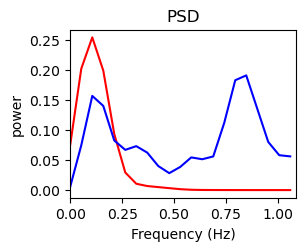

In [218]:
# Check the length of your signal
physio_high_cue_mean = np.mean(np.vstack(physio_high_cue), axis=0)
fmri_high_cue_mean = np.mean(np.vstack(fmri_high_cue), axis=0)
signal_length = len(physio_high_cue_mean)
ws = int(Fs * 9) 
window = hann(ws)
noverlap = ws // 2
nfft = signal_length

f, Pxx = welch(np.array(physio_high_cue_mean), Fs, window=window, noverlap=noverlap, nfft=nfft)
_, Pyy = welch(np.array(fmri_high_cue_mean), Fs, window=window, noverlap=noverlap, nfft=nfft)

plt.subplot(222)
plt.plot(f, np.abs(Pxx), 'r', f, np.abs(Pyy), 'b')
plt.xlim([0, Fs/2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('power')
plt.title('PSD for High cue')

In [249]:
signal_length

41

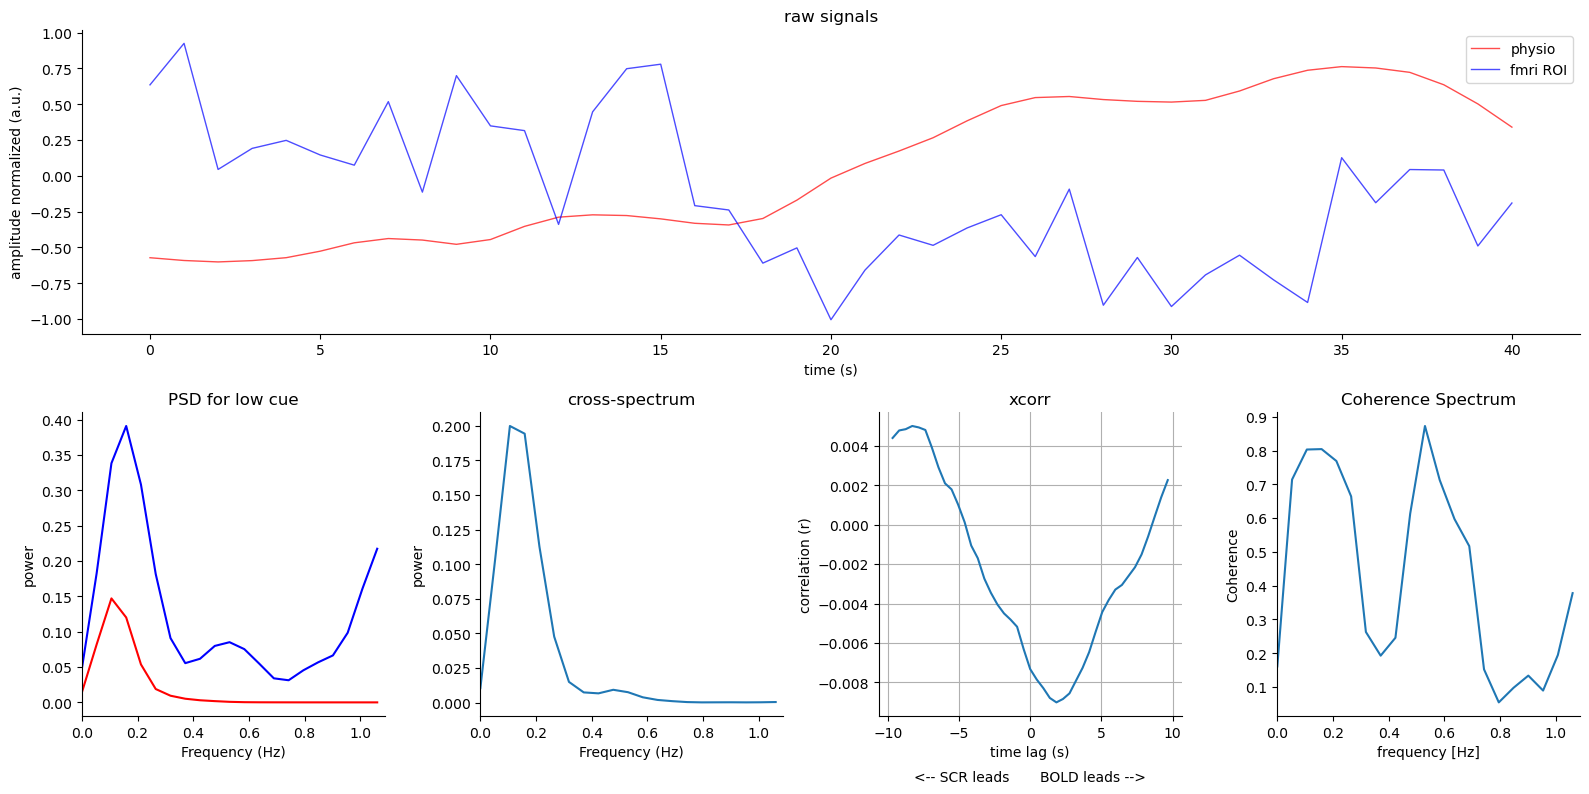

max value: 0.009013173977970648, max lag: 1.84


In [250]:
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, :]) # Wide subplot on row 1
ax2 = fig.add_subplot(gs[1, 0]) # Subplot 1 on row 2
ax3 = fig.add_subplot(gs[1, 1]) # Subplot 2 on row 2
ax4 = fig.add_subplot(gs[1, 2]) # Subplot 3 on row 2
ax5 = fig.add_subplot(gs[1, 3]) # Subplot 3 on row 2

physio_low_cue_mean = np.mean(np.vstack(physio_low_cue), axis=0).T
fmri_low_cue_mean = np.mean(np.vstack(fmri_low_cue), axis=0).T
signal_length = len(physio_low_cue_mean)
# plt 1: Plot raw signals ______________________________
ax1.plot(np.arange(signal_length), physio_low_cue_mean, 'r', linewidth=1, alpha=0.7)
ax1.plot(np.arange(signal_length), fmri_low_cue_mean, 'b', linewidth=1, alpha=0.7)
ax1.legend(['physio', f'fmri ROI'])
ax1.set_xlabel('time (s)')
ax1.set_ylabel('amplitude normalized (a.u.)')
ax1.set_title('raw signals')

# Check the length of your signal

ws = int(Fs * 9) 
window = hann(ws)
noverlap = ws // 2
nfft = signal_length

f, Pxx = welch(np.array(physio_low_cue_mean), Fs, window=window, noverlap=noverlap, nfft=nfft)
_, Pyy = welch(np.array(fmri_low_cue_mean), Fs, window=window, noverlap=noverlap, nfft=nfft)


ax2.plot(f, np.abs(Pxx), 'r', f, np.abs(Pyy), 'b')
ax2.set_xlim([0, Fs/2])


ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('power')
ax2.set_title('PSD for low cue')



# plot 3: Compute and plot cross-spectrum
f, Pxy = csd(np.array(physio_low_cue_mean), np.array(fmri_low_cue_mean), Fs, window=window, noverlap=noverlap, nfft=nfft)

# plt.subplot(223)
ax3.plot(f, np.abs(Pxy))
ax3.set_xlim([0, Fs/2]) # Nyquist frequency is the upper bound
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('power')
ax3.set_title('cross-spectrum')

# plot4: Compute and plot cross-correlation
maxlags = int(Fs * 10)
acf = correlate(np.array(physio_low_cue_mean), np.array(fmri_low_cue_mean), mode='full', method='direct')
# crossSD = abs(Pxy)**2/(Pxx*Pyy)
norm_factor = np.sqrt(np.sum(data1**2) * np.sum(data2**2))
acf_normalized = acf / norm_factor
# Calculate auto-correlations at lag 0
# auto_corr_data1 = np.sum(data1 ** 2)
# auto_corr_data2 = np.sum(data2 ** 2)

# Normalize cross-correlation
# acf_normalized = acf / np.sqrt(auto_corr_data1 * auto_corr_data2)

# acf /= len(data1)  # Normalizing
lags = np.arange(-maxlags, maxlags + 1) * (1./Fs)

# plt.subplot(224)
ax4.plot(lags[len(lags)//2-maxlags:len(lags)//2+maxlags+1], acf_normalized[len(acf_normalized)//2-maxlags:len(acf_normalized)//2+maxlags+1])

# ax4.plot(lags[len(lags)//2-maxlags:len(lags)//2+maxlags+1], acf[len(acf)//2-maxlags:len(acf)//2+maxlags+1])
ax4.grid(True)
ax4.set_xlabel('time lag (s)')
ax4.set_ylabel('correlation (r)')
ax4.set_title('xcorr')
ax4.text(0.5, -0.2, '<-- SCR leads       BOLD leads -->', ha='center', va='center', transform=ax4.transAxes)


# plot 5

f_coh, Cxy = coherence(np.array(physio_low_cue_mean), np.array(fmri_low_cue_mean), Fs, window=hann(ws), noverlap=noverlap, nfft=nfft)
ax5.plot(f_coh, Cxy)
ax5.set_xlim([0, Fs/2])  # Limit to Nyquist frequency

ax5.set_xlabel('frequency [Hz]')
ax5.set_ylabel('Coherence')
ax5.set_title('Coherence Spectrum')
# Show the figure
plt.tight_layout()
sns.despine()
plt.show()


acf_sliced = acf_normalized[len(acf_normalized)//2-maxlags:len(acf_normalized)//2+maxlags+1]
lags_sliced = lags[len(lags)//2-maxlags:len(lags)//2+maxlags+1]
absolute_values = [abs(number) for number in acf_sliced]  # Convert all numbers to their absolute values
# absolute_max_value = max(absolute_values) 
max_acf_value = np.max(absolute_values)
max_acf_index = np.argmax(absolute_values)
max_lag_time = lags_sliced[max_acf_index]
print(f"max value: {max_acf_value}, max lag: {max_lag_time}")

## cumulative PSD

In [226]:
frequencies

array([0.        , 0.05302227, 0.10604454, 0.15906681, 0.21208908,
       0.26511135, 0.31813362, 0.37115589, 0.42417815, 0.47720042,
       0.53022269, 0.58324496, 0.63626723, 0.6892895 , 0.74231177,
       0.79533404, 0.84835631, 0.90137858, 0.95440085, 1.00742312,
       1.06044539])

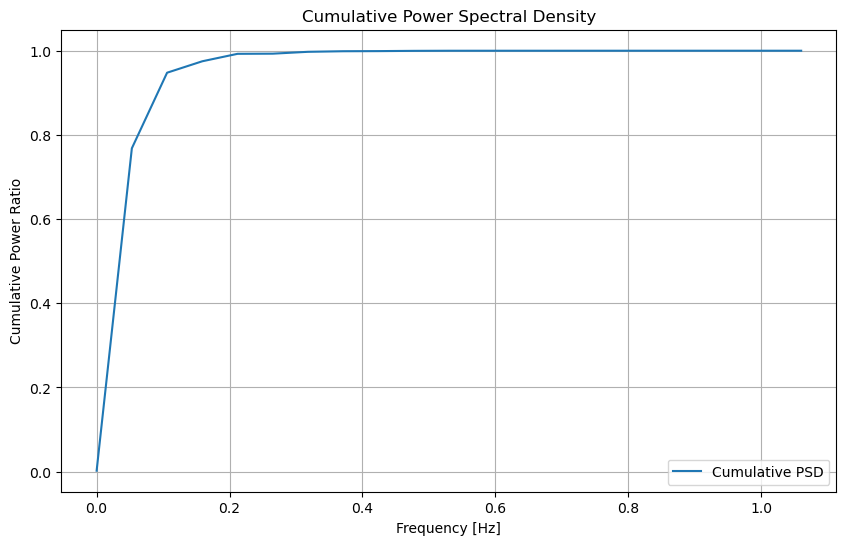

The frequency at the first 5% of cumulative power is: 0.053022269353128315 Hz


In [233]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Assume signal and Fs are defined
# signal = np.array(your_signal)
# Fs = your_sampling_frequency

# Compute the PSD
frequencies, power_density = welch(physio_low_cue_mean, Fs)

# Calculate the cumulative sum of the power spectral density
cumulative_power_density = np.cumsum(power_density)

# Normalize cumulative power to the total power (to get a ratio)
cumulative_power_density_normalized = cumulative_power_density / cumulative_power_density[-1]

# Plot the cumulative power spectrum density
plt.figure(figsize=(10, 6))
plt.plot(frequencies, cumulative_power_density_normalized, label='Cumulative PSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Cumulative Power Ratio')
plt.title('Cumulative Power Spectral Density')
plt.grid(True)
plt.legend()
plt.show()

# Find the first 5% of the total power
threshold = 0.05  # 5%
index_of_first_5_percent = np.argmax(cumulative_power_density_normalized >= threshold)
frequency_at_5_percent = frequencies[index_of_first_5_percent]

print(f"The frequency at the first 5% of cumulative power is: {frequency_at_5_percent} Hz")


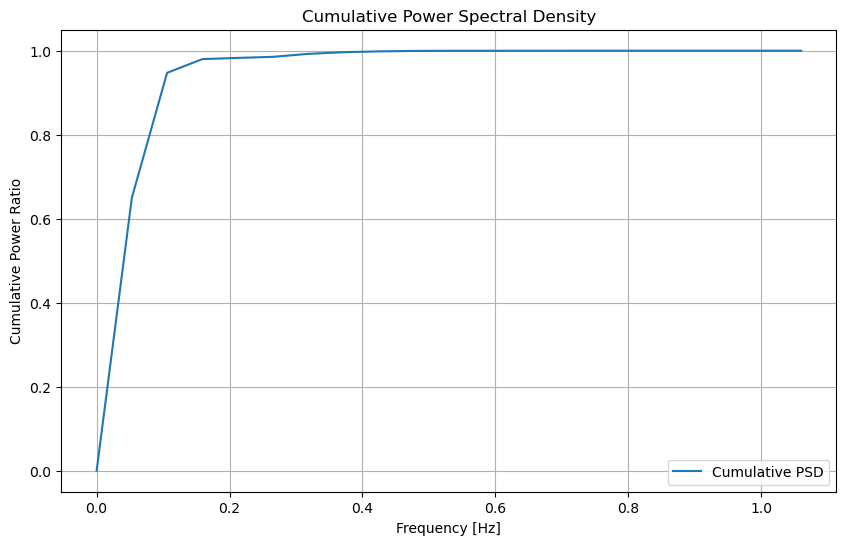

The frequency at the first 5% of cumulative power is: 0.053022269353128315 Hz


In [243]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Assume signal and Fs are defined
# signal = np.array(your_signal)
# Fs = your_sampling_frequency

# Compute the PSD
frequencies, power_density = welch(physio_high_cue_mean, Fs)

# Calculate the cumulative sum of the power spectral density
cumulative_power_density = np.cumsum(power_density)

# Normalize cumulative power to the total power (to get a ratio)
cumulative_power_density_normalized = cumulative_power_density / cumulative_power_density[-1]

# Plot the cumulative power spectrum density
plt.figure(figsize=(10, 6))
plt.plot(frequencies, cumulative_power_density_normalized, label='Cumulative PSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Cumulative Power Ratio')
plt.title('Cumulative Power Spectral Density')
plt.grid(True)
plt.legend()
plt.show()

# Find the first 5% of the total power
threshold = 0.001  # 5%
index_of_first_5_percent = np.argmax(cumulative_power_density_normalized >= threshold)
frequency_at_5_percent = frequencies[index_of_first_5_percent]

print(f"The frequency at the first 5% of cumulative power is: {frequency_at_5_percent} Hz")


In [224]:
cumulative_power_density_normalized.shape

(22,)